# Load

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_json('json/corpus.json')
df = df.reset_index().drop(columns = ['index'])

In [3]:
df.head(1)

track_id   title_billboard artist_billboard  \
0  5ayybTSXNwcarDtxQKqvWX  Poor Little Fool     Ricky Nelson   

                   title_spotify artist_spotify  root  time_signature  mode  \
0  Poor Little Fool - Remastered   Ricky Nelson     0               4     1   

     tempo  loudness  duration_ms  energy  valence  \
0  154.999   -11.573       153933   0.332    0.795   

                                          genre_list    weeks_list ranks_list  \
0  [adult standards, brill building pop, bubblegu...  [1958-08-08]        [1]   

  highest_rank  
0            1

# Functions

In [5]:
def mean_confidence_interval(data, confidence = 0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [6]:
def compute_bounds(features, feature):
    
    lower_bound, mean, upper_bound = [], [], []

    # Compute the 95% confidence interval
    for week in range(len(features[feature])):
        m, lb, ub = mean_confidence_interval(features[feature][week])
    
        lower_bound.append(lb)
        mean.append(m)
        upper_bound.append(ub)
        
    return lower_bound, mean, upper_bound

In [32]:
def plot_feature_evolution(features, feature, color = 'b', N = 48, granularity = 'Weeks', unit = ''):
    
    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=1.5)
    
    years = np.arange(1959, 1997)
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*N, N), years, rotation = 'vertical')
    plt.xlabel('\n' + granularity)
    plt.ylabel(name + ' ' + unit)
    plt.title(name + ' change at ' + granularity.lower()[:-1] + ' granularity \n')

    return plt

In [141]:
def plot_discrete_feature_evolution(features, feature, granularity = 'Weeks', categories = ''):
    
    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=1.5)
    
    years = np.arange(1959, 1996)
    
    all_entries = []
    for i in range(len(features[feature])):
        list_ = features[feature][i]
        for element in list_:
            all_entries.append(element)
        
    dico = {}
    keys = sorted(pd.Series(all_entries).value_counts().keys().tolist())
    for key in keys:
        dico[key] = []

    for timespan in range(len(features)):
        entries = features[feature][timespan]
        serie = pd.Series(entries).value_counts()
        count = np.sum(serie.values)
        for key in keys:
            try:
                dico[key].append(serie[key]/count)
            except:
                dico[key].append(0.)

    name = feature.replace('_', ' ').capitalize()
    xlabel = granularity
    ylabel = name + ' (relative share)'
    title = name + ' change at ' + granularity.lower()[:-1] + ' granularity \n'
    
    df_dico = pd.DataFrame(dico, index = years)
    
    if categories != '':
        for i in range(len(df_dico.columns)):
            df_dico = df_dico.rename(columns = {df_dico.columns[i]: categories[i]})
        
    ax = df_dico.plot.area(legend = 'reverse', title = title)    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return ax

In [110]:
def salient_drift(features, feature, means, N = 48, granularity = 'Weeks'):
    
    color = '#989898'
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    salient_low, salient_high = [], []
    ampl_low, ampl_high = [], []
    
    for i in range(len(lower_bound)):
        if lower_bound[i] > means[feature]:
            salient_high.append(i)
            ampl_high.append(mean[i])
            
        if upper_bound[i] < means[feature]:
            salient_low.append(i)
            ampl_low.append(mean[i])

    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    
    years = np.arange(1959, 1997)
    #plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    plt.plot(salient_low, ampl_low, color='#01B9FF', marker='o', linestyle = '')
    plt.plot(salient_high, ampl_high, color='#FF0101', marker='o', linestyle = '')
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*N, N), years, rotation = 'vertical')
    plt.xlabel(granularity)
    plt.ylabel(name)
    plt.title(name + ' salient drifts at ' + granularity.lower()[:-1] + ' granularity \n')

    return plt, salient_low, salient_high

# Weeks

In [3]:
all_weeks = []

for ind, item in df['weeks_list'].iteritems():
    for week in item:
        all_weeks.append(week)
        
weeks = pd.Series(all_weeks).value_counts().index

In [4]:
weeks = sorted(weeks)[1:]

In [6]:
features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

keys = features.keys()

for week in weeks :
    week_features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
        
    for ind, row in df.iterrows():
        if week in row['weeks_list']: 
            for key in keys:
                if float(row[key]) != -1.:
                    week_features[key].append(row[key])
    
    for key in keys:
        features[key].append(week_features[key])

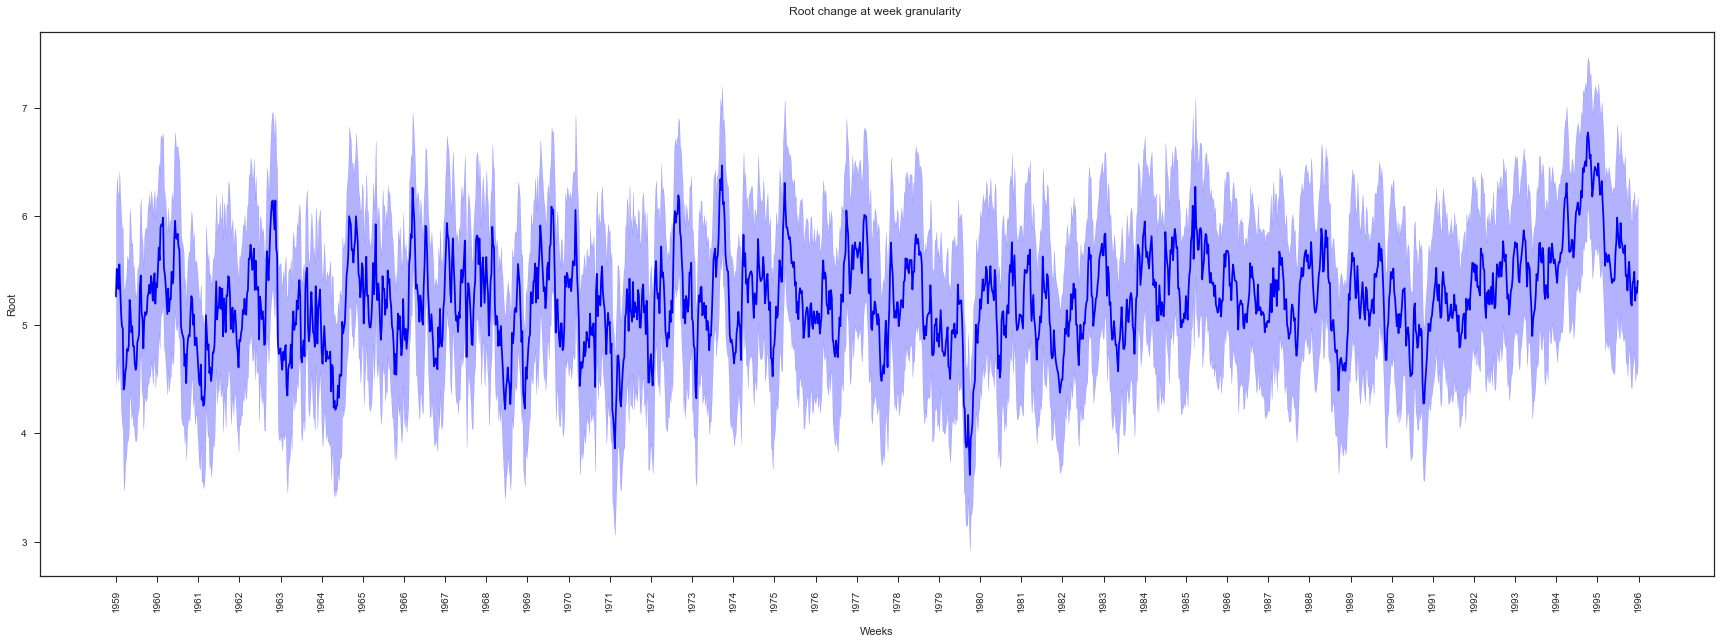

In [10]:
plot_feature_evolution(features, 'root');

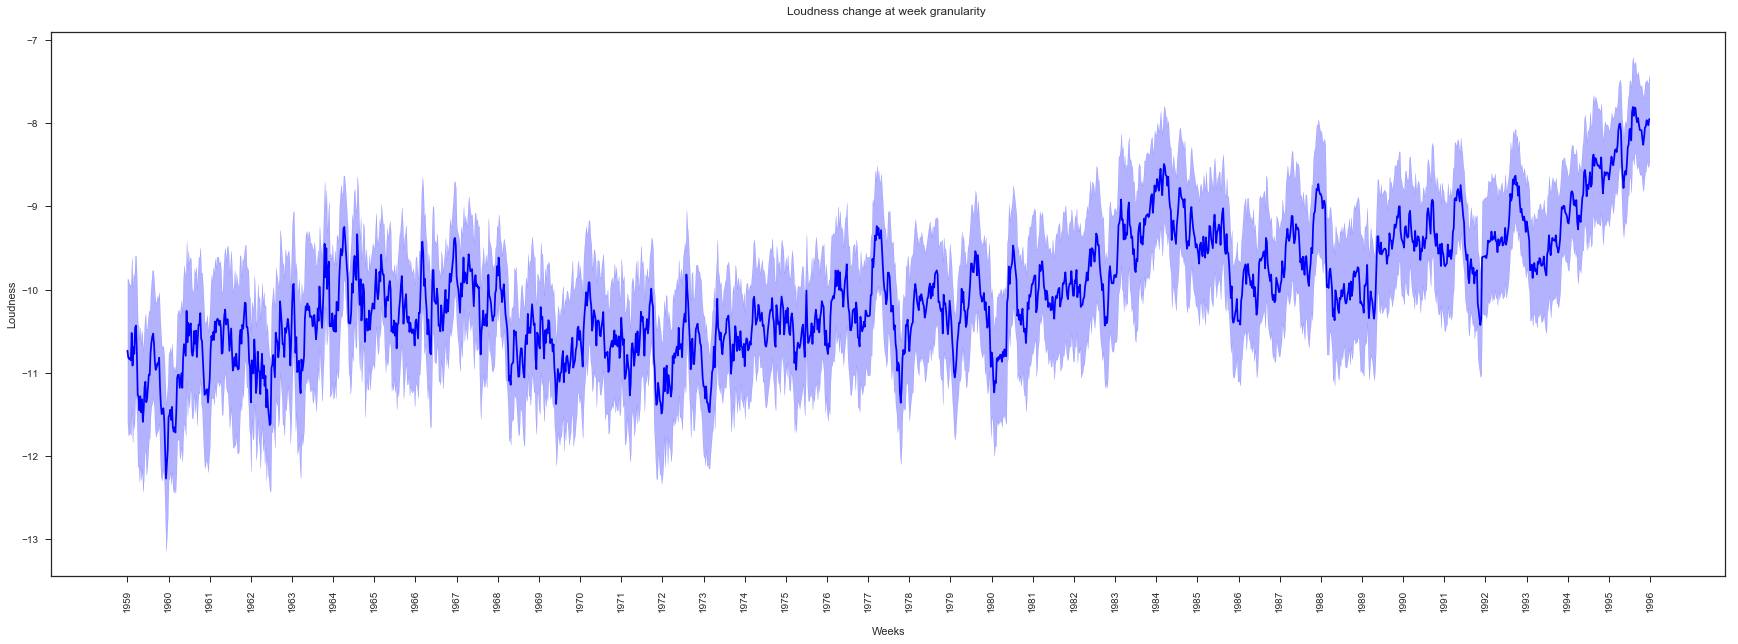

In [11]:
plot_feature_evolution(features, 'loudness');

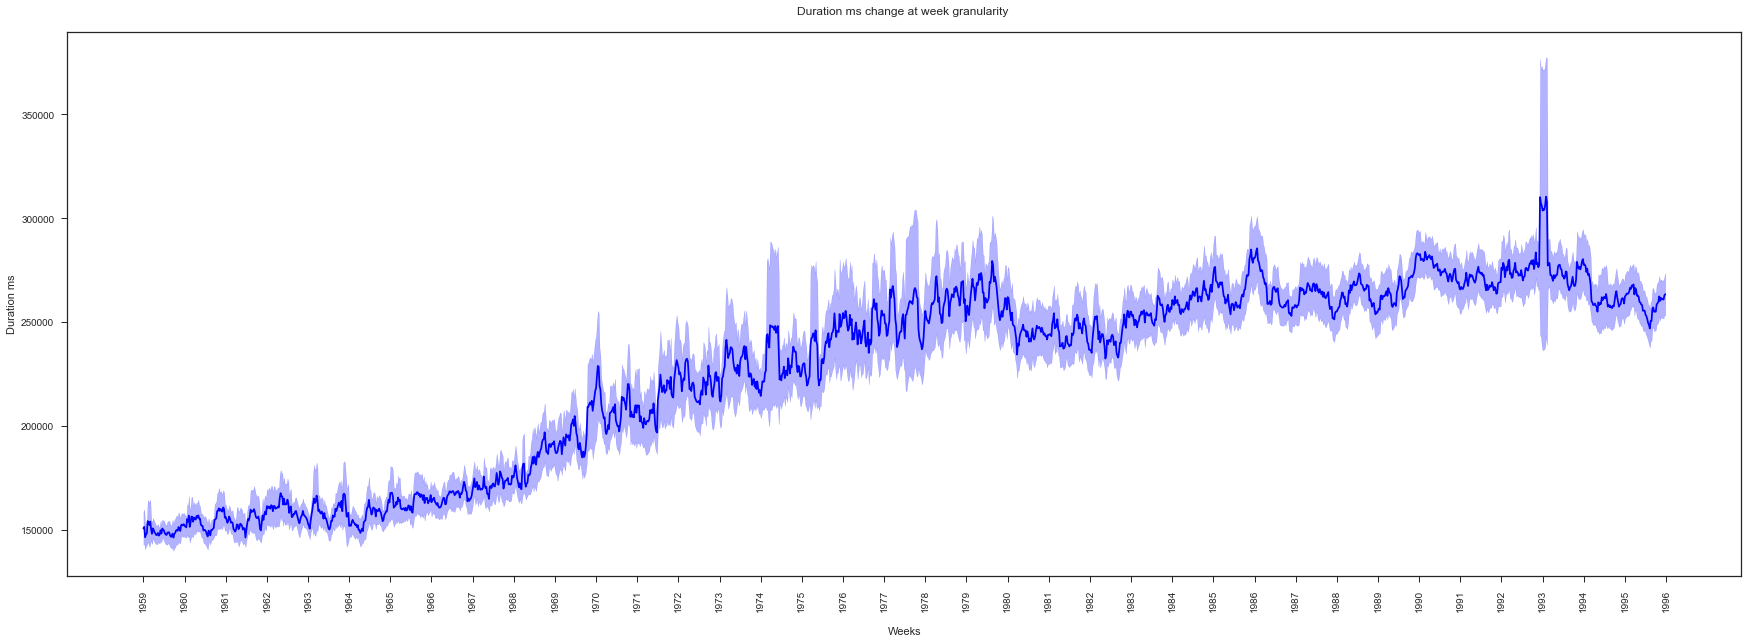

In [12]:
plot_feature_evolution(features, 'duration_ms');

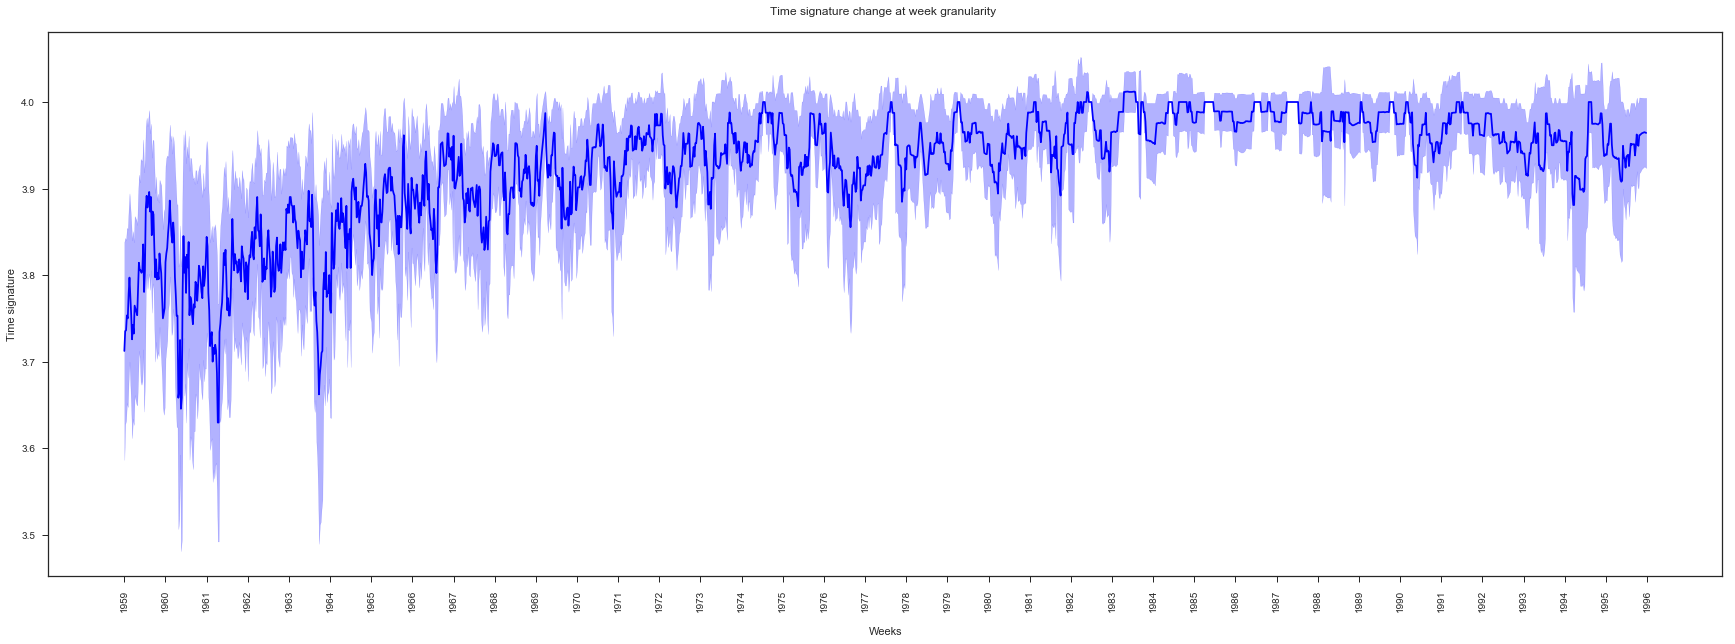

In [13]:
plot_feature_evolution(features, 'time_signature');

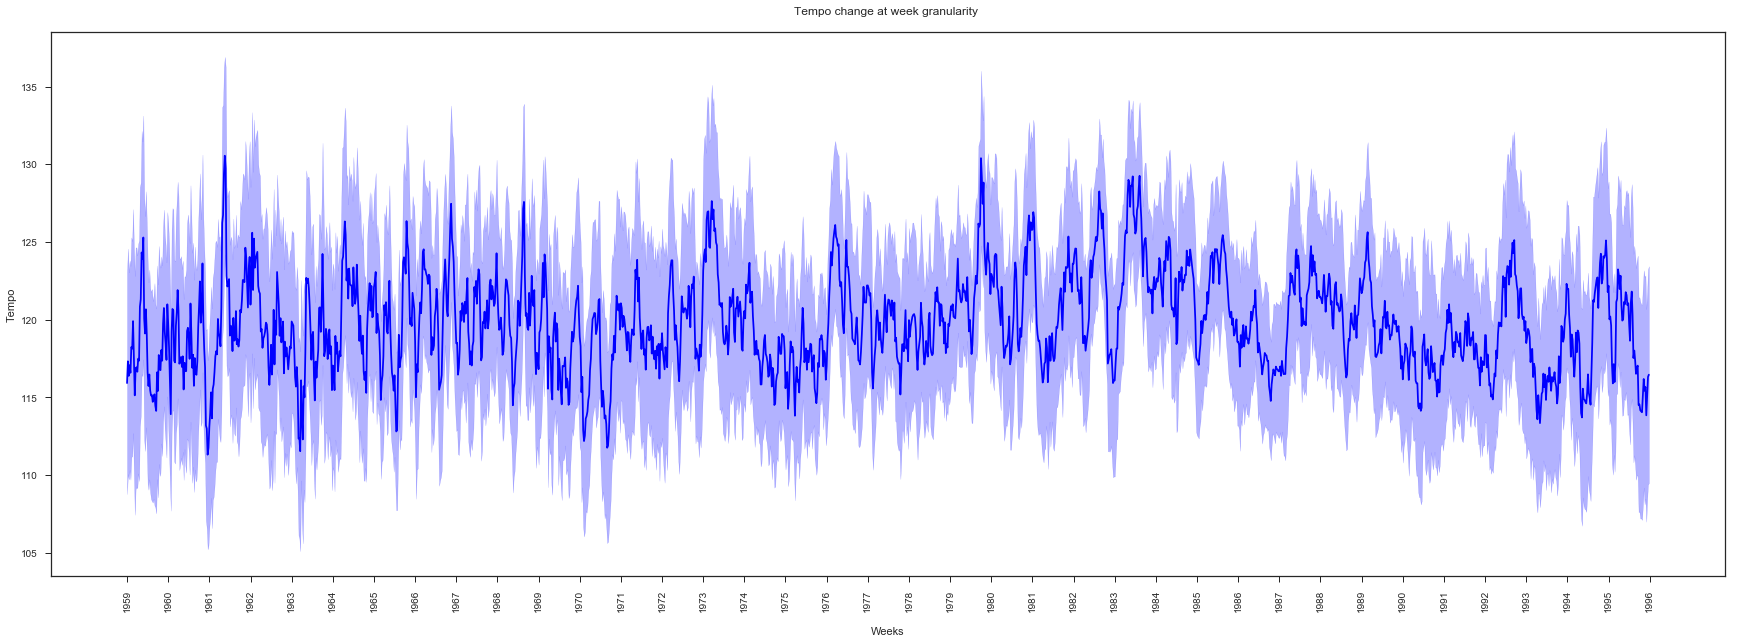

In [14]:
plot_feature_evolution(features, 'tempo');

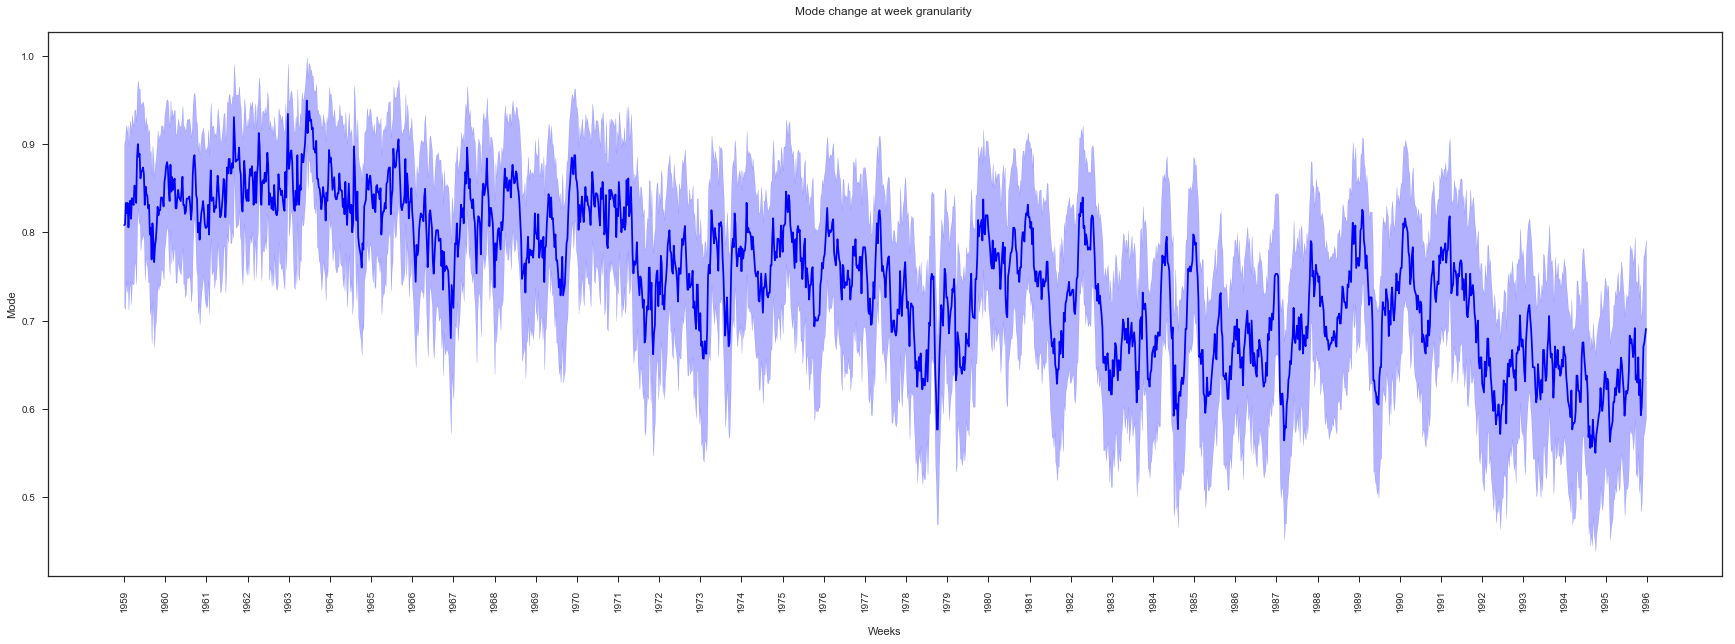

In [15]:
plot_feature_evolution(features, 'mode');

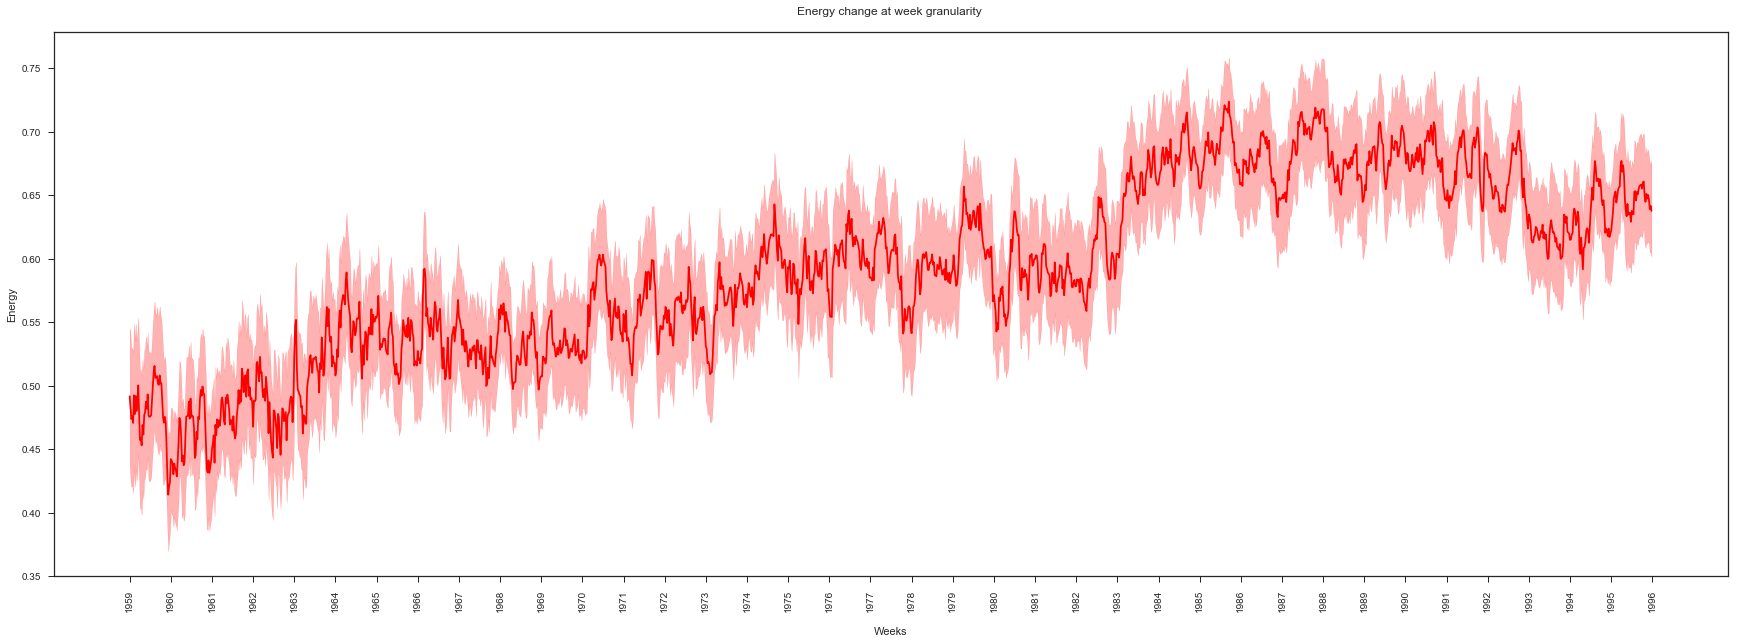

In [16]:
plot_feature_evolution(features, 'energy', color = 'r');

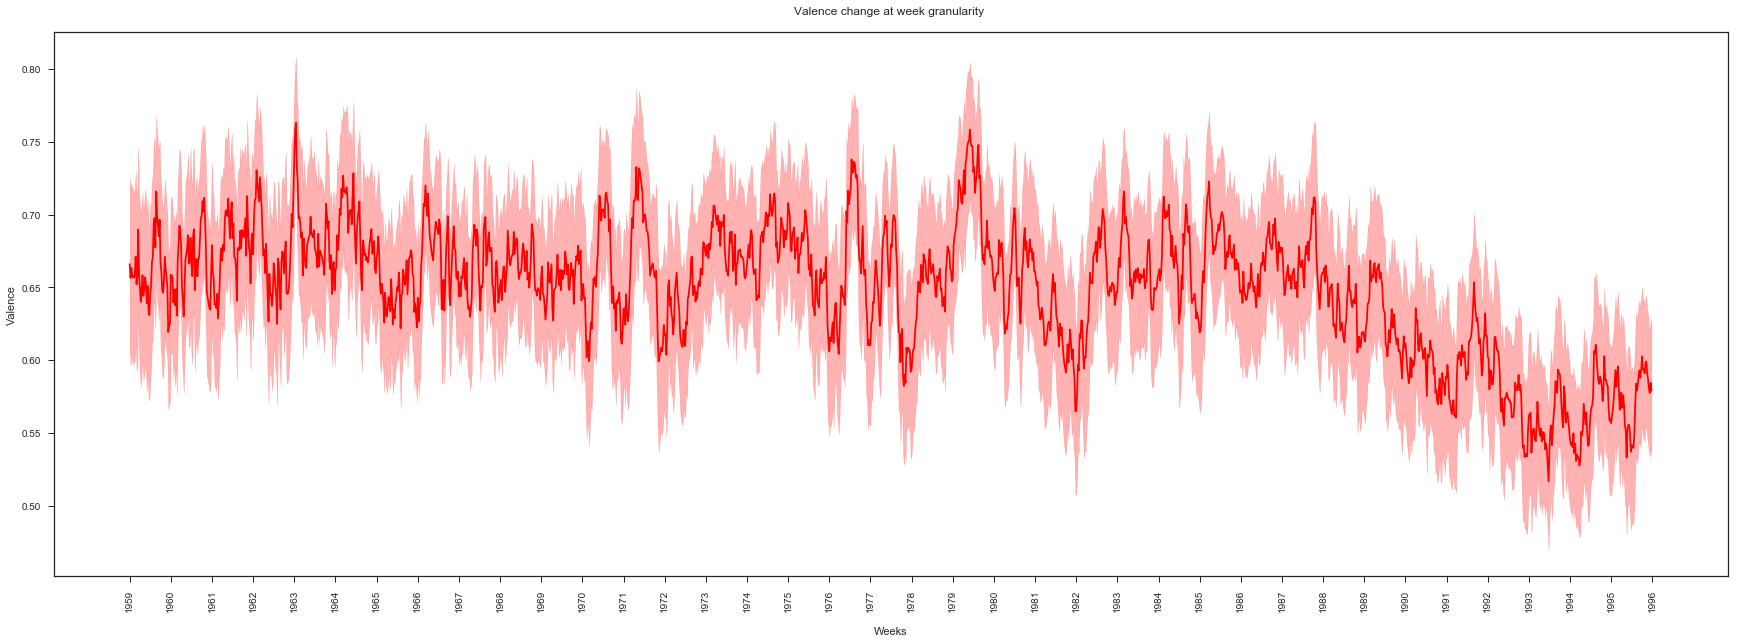

In [17]:
plot_feature_evolution(features, 'valence', color = 'r');

In [18]:
trend = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

for key in trend.keys():
    for i in range(len(weeks)):
        trend[key].append(np.mean(features[key][i]))

In [19]:
df_trend = pd.DataFrame(trend)

In [20]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("ticks")

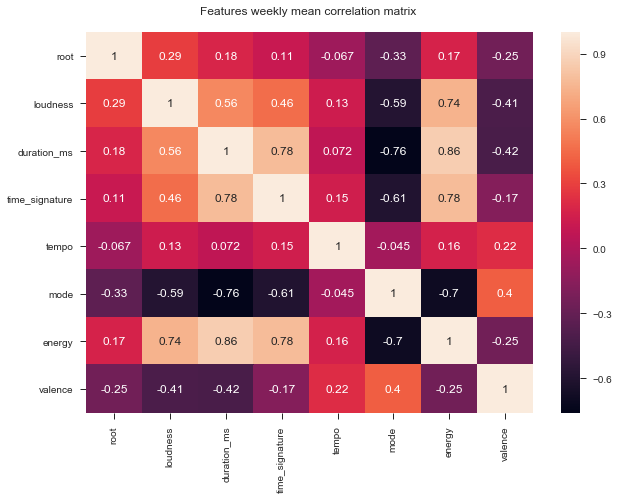

In [21]:
sns.heatmap(df_trend.corr(), annot=True).set_title('Features weekly mean correlation matrix \n');

## Horizontal salience

In [23]:
means = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

for key in trend.keys():
    means[key] = np.mean(trend[key])

In [25]:
salient_low_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
salient_high_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

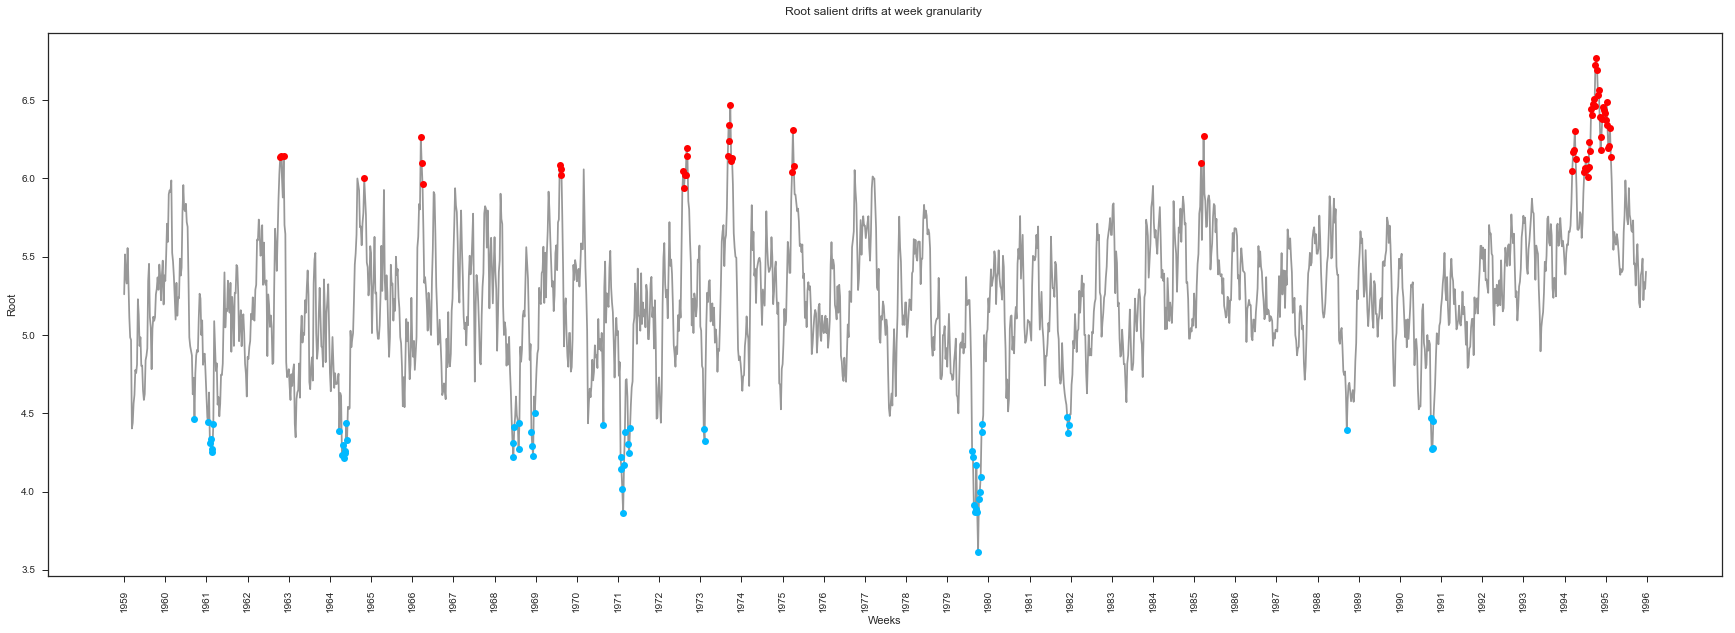

In [26]:
feature = 'root'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

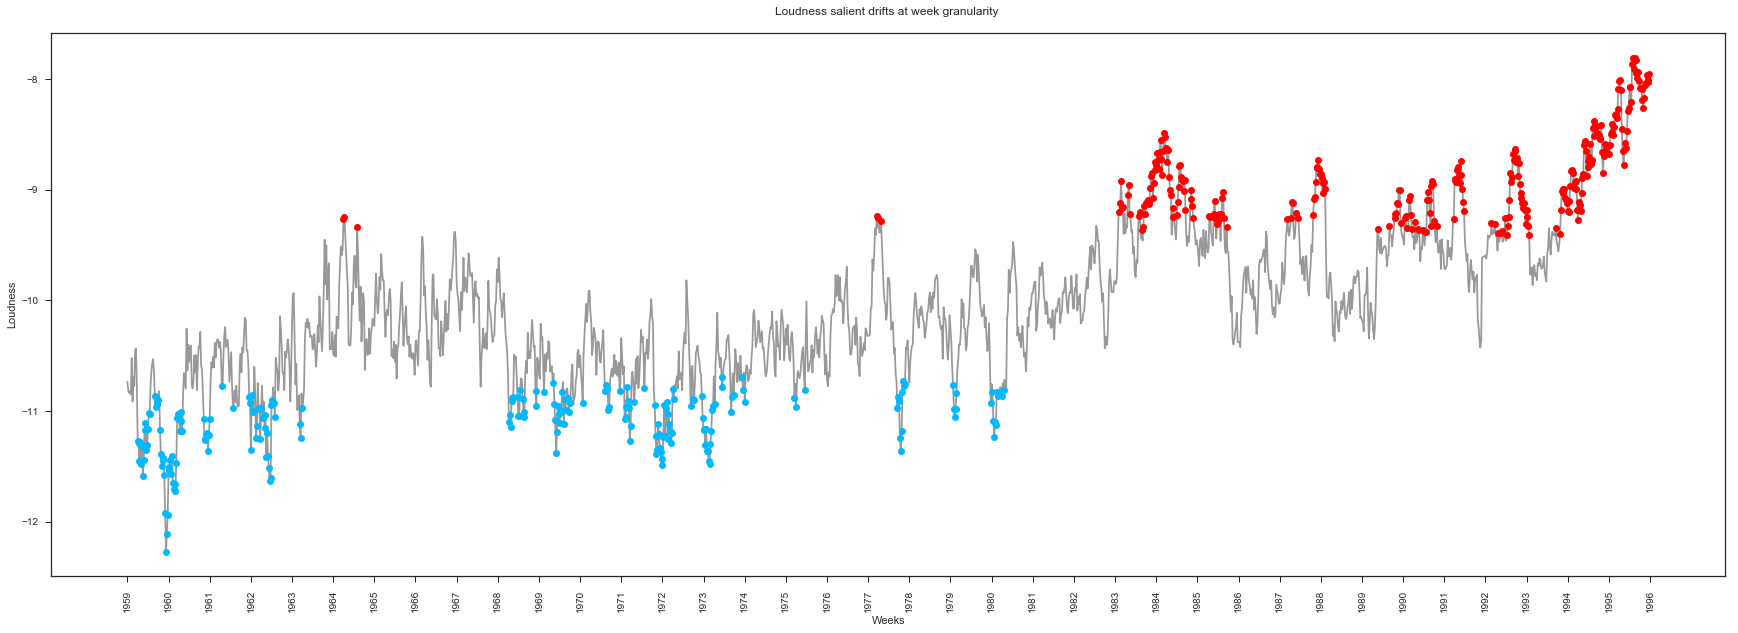

In [27]:
feature = 'loudness'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

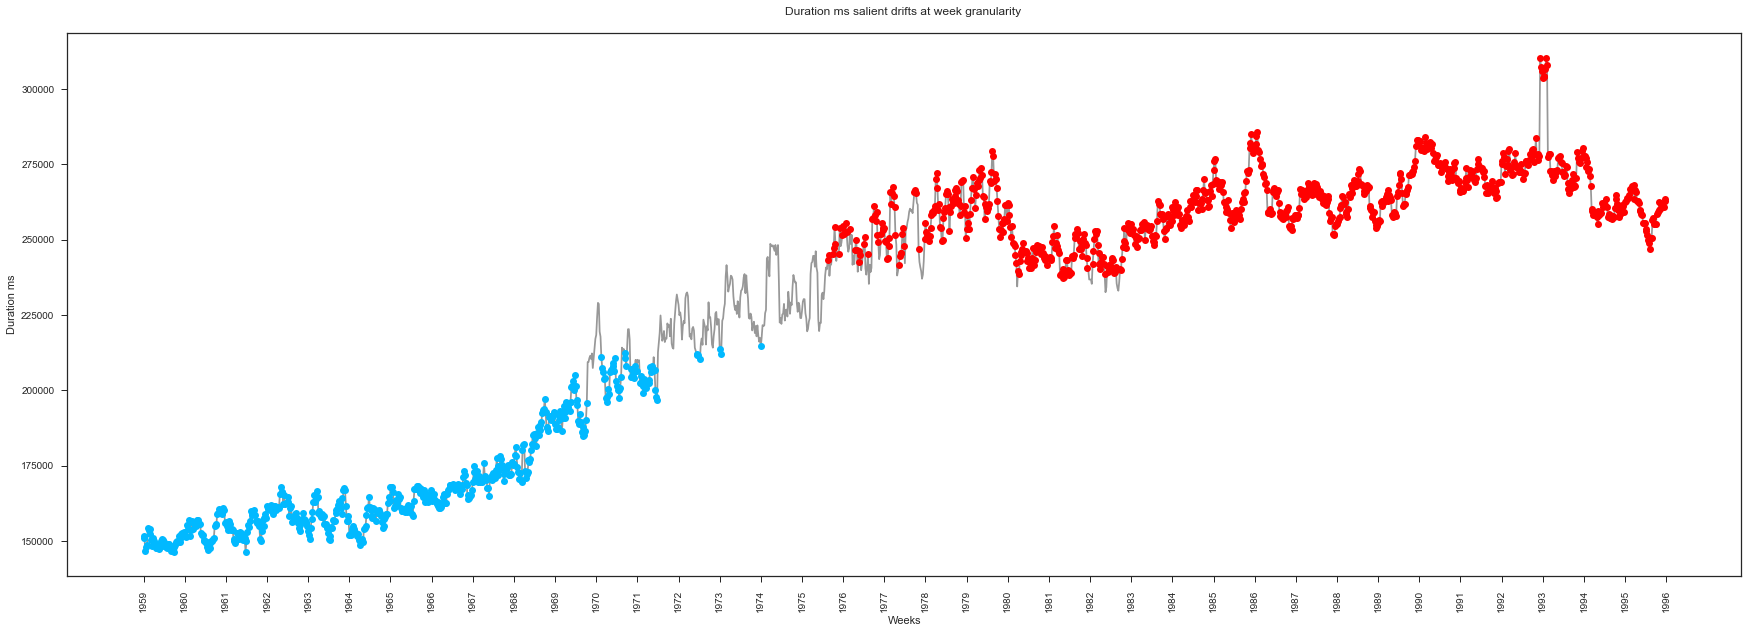

In [28]:
feature = 'duration_ms'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

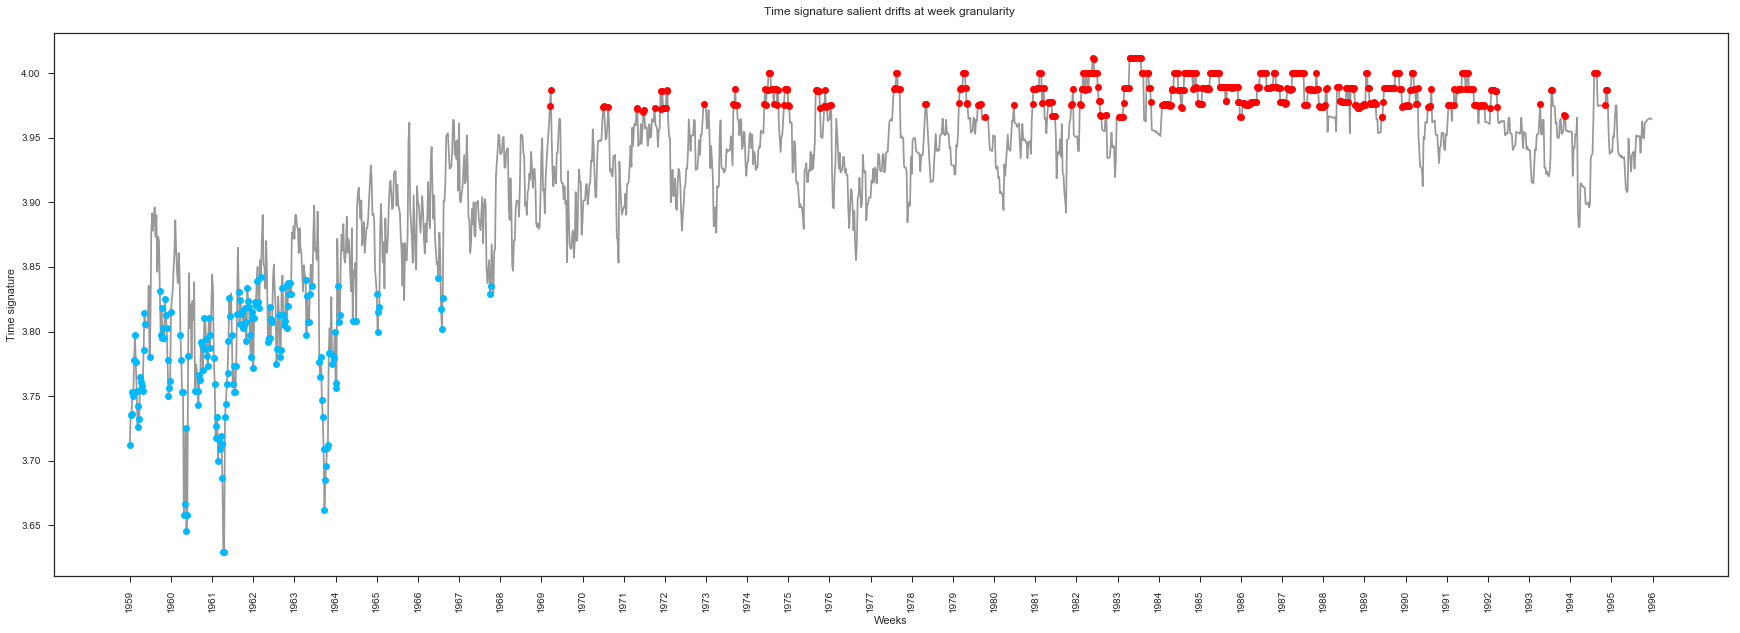

In [29]:
feature = 'time_signature'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

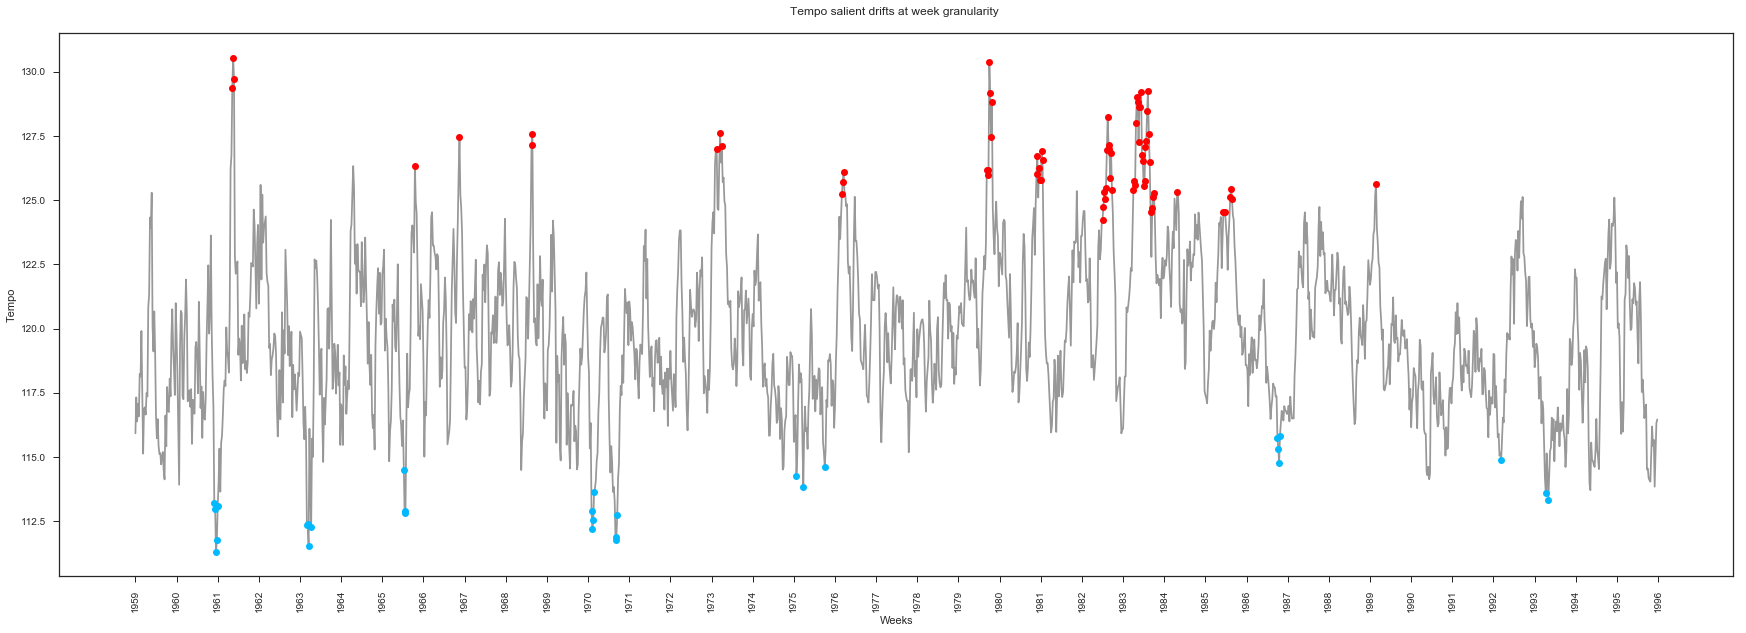

In [30]:
feature = 'tempo'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

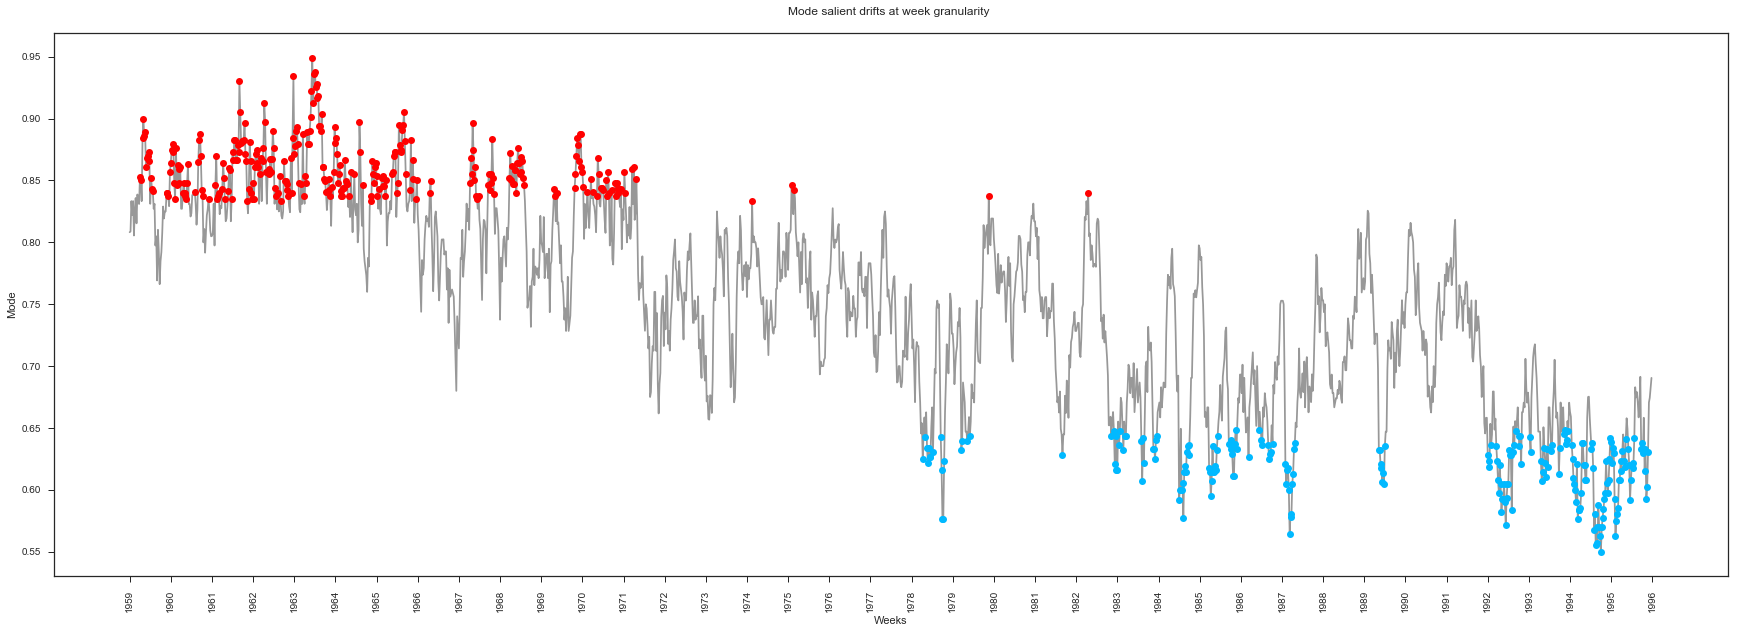

In [31]:
feature = 'mode'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

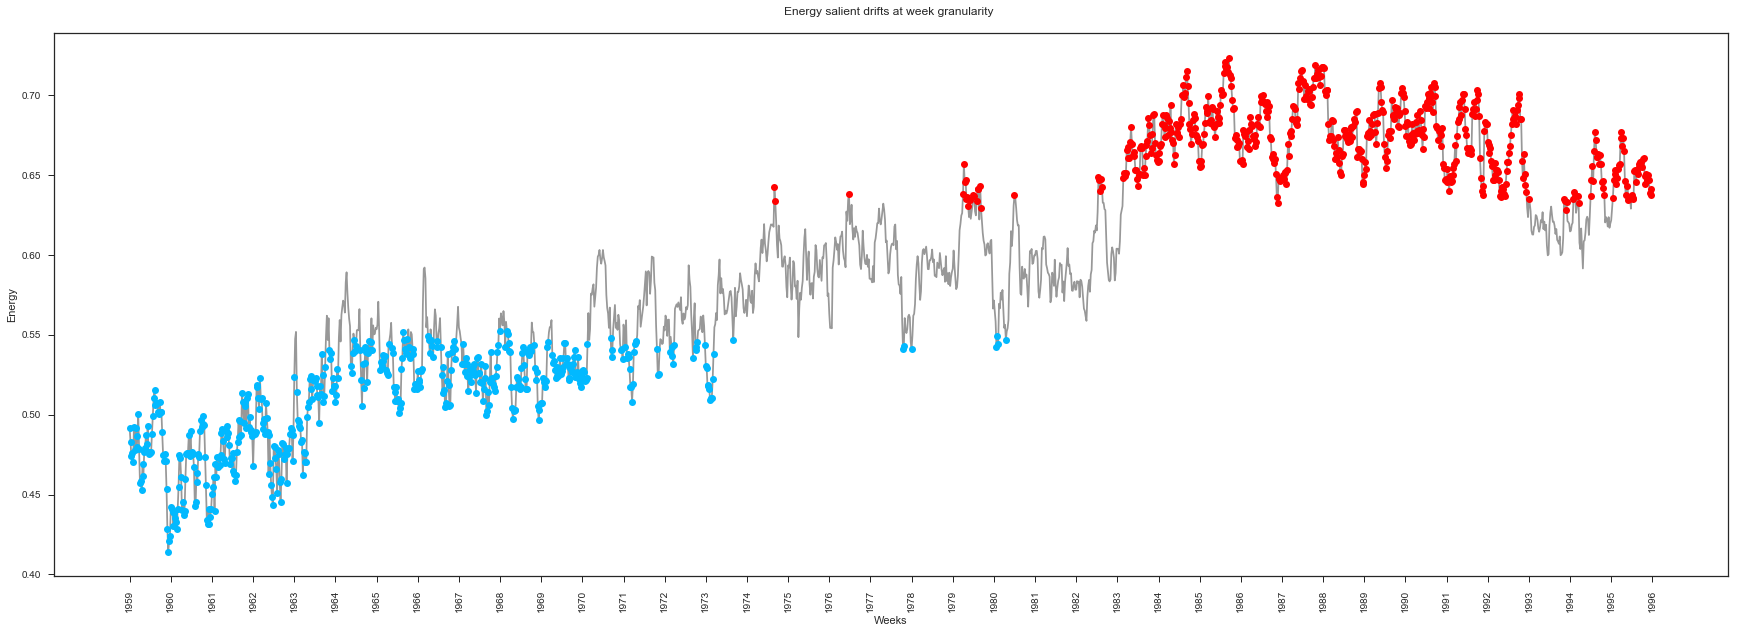

In [32]:
feature = 'energy'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

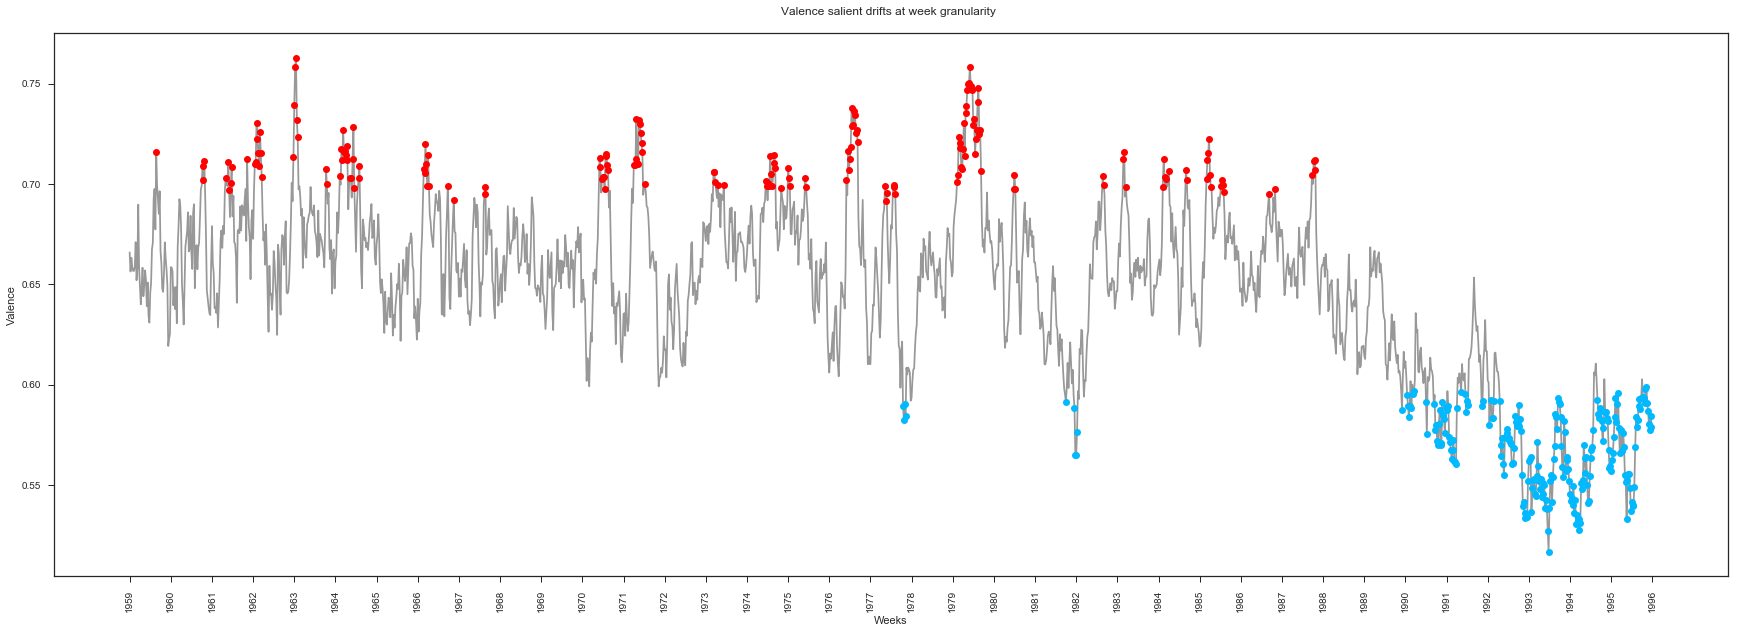

In [33]:
feature = 'valence'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

In [34]:
explanative_features = ['root', 'loudness', 'time_signature', 'tempo', 'mode', 'valence']
keep_low, keep_high = [], []

for key in salient_low_list.keys():
    if (key != 'duration_ms') & (key != 'energy'):
        for element in salient_low_list[key]:
            keep_low.append(element)

for key in salient_high_list.keys():
    if (key != 'duration_ms') & (key != 'energy'):
        for element in salient_high_list[key]:
            keep_high.append(element)

In [35]:
keep_low = pd.Series(keep_low).value_counts()
keep_high = pd.Series(keep_high).value_counts()

In [36]:
weeks = pd.Series(weeks)

In [37]:
salient_low = keep_low[keep_low.values >= 4].index
weeks[salient_low].sort_values()

Series([], dtype: object)

In [38]:
salient_high = keep_high[keep_high.values >= 4].index
weeks[salient_high].sort_values()

Series([], dtype: object)

# Months

In [39]:
months_list = []

for ind, item in df['weeks_list'].iteritems():
    occurences = [] 
    
    for week in item:
        month = week[:7]
        if not(month in occurences):
            occurences.append(month)
            
    months_list.append(occurences)
    
df['months_list'] = months_list

In [40]:
all_months = []

for ind, item in df['months_list'].iteritems():
    for month in item:
        all_months.append(month)
        
months = pd.Series(all_months).value_counts().index

In [41]:
months = sorted(months)[1:]

In [42]:
monthly_features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [43]:
keys = monthly_features.keys()

for month in months :
    month_features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
        
    for ind, row in df.iterrows():
        if month in row['months_list']: 
            for key in keys:
                if float(row[key]) != -1.:
                    month_features[key].append(row[key])
    
    for key in keys:
        monthly_features[key].append(month_features[key])

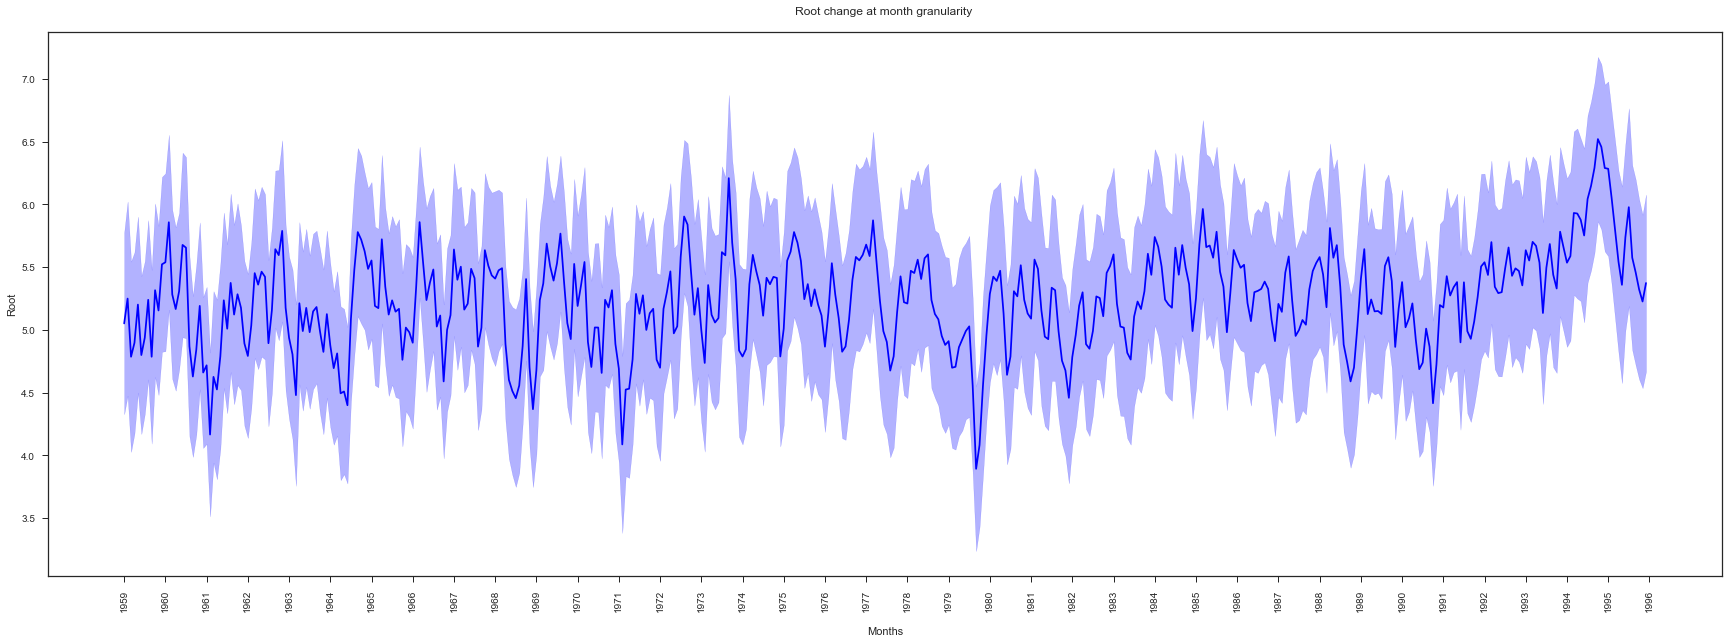

In [44]:
plot_feature_evolution(monthly_features, 'root', N = 12, granularity = 'Months');

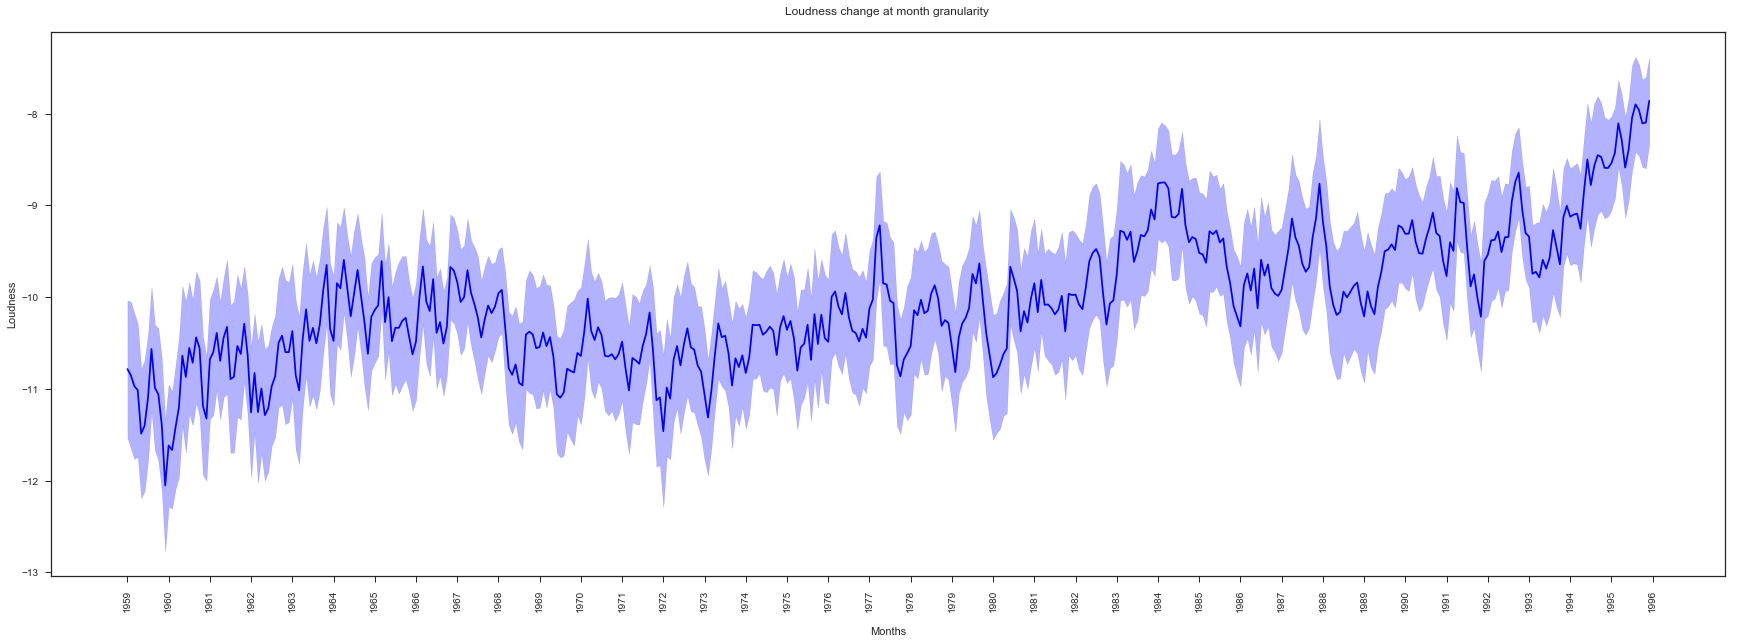

In [45]:
plot_feature_evolution(monthly_features, 'loudness', N = 12, granularity = 'Months');

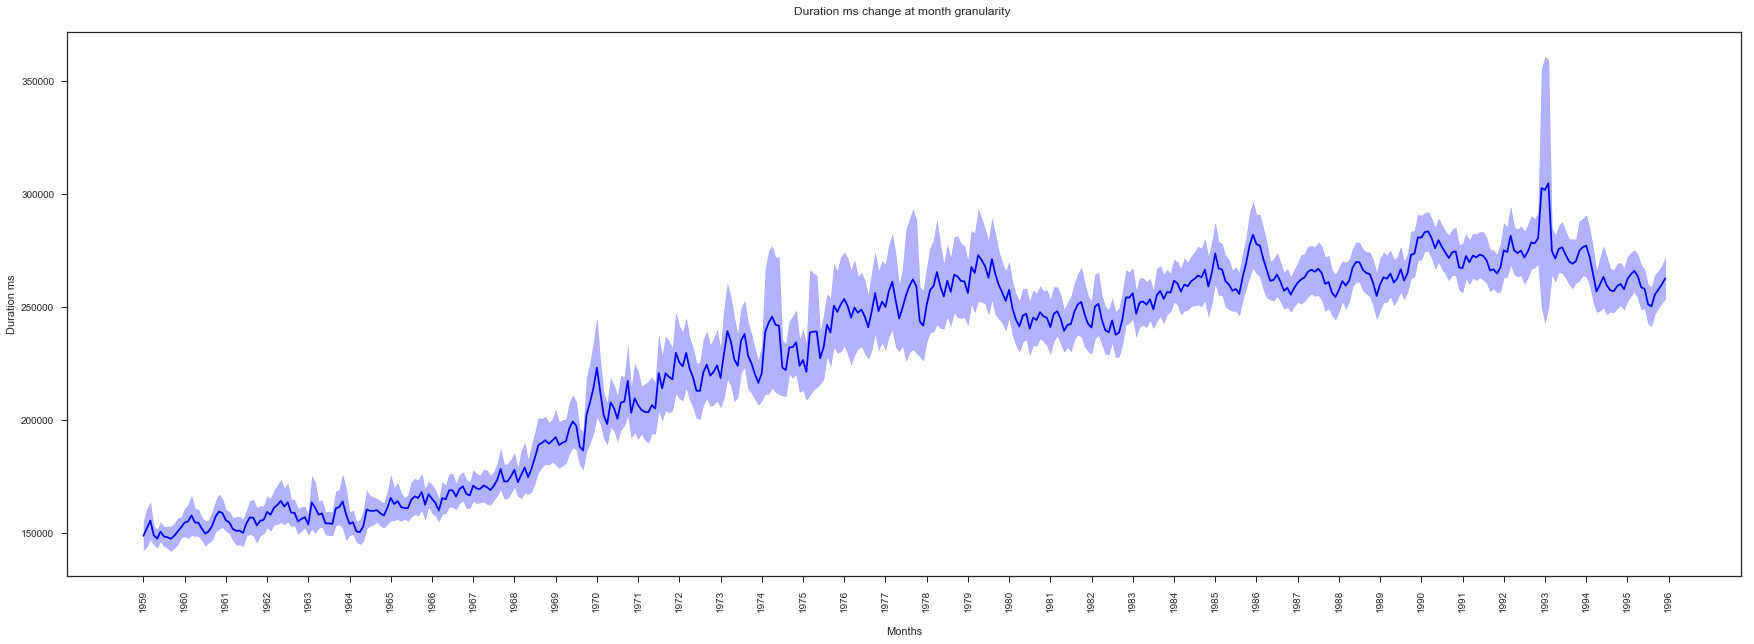

In [46]:
plot_feature_evolution(monthly_features, 'duration_ms', N = 12, granularity = 'Months');

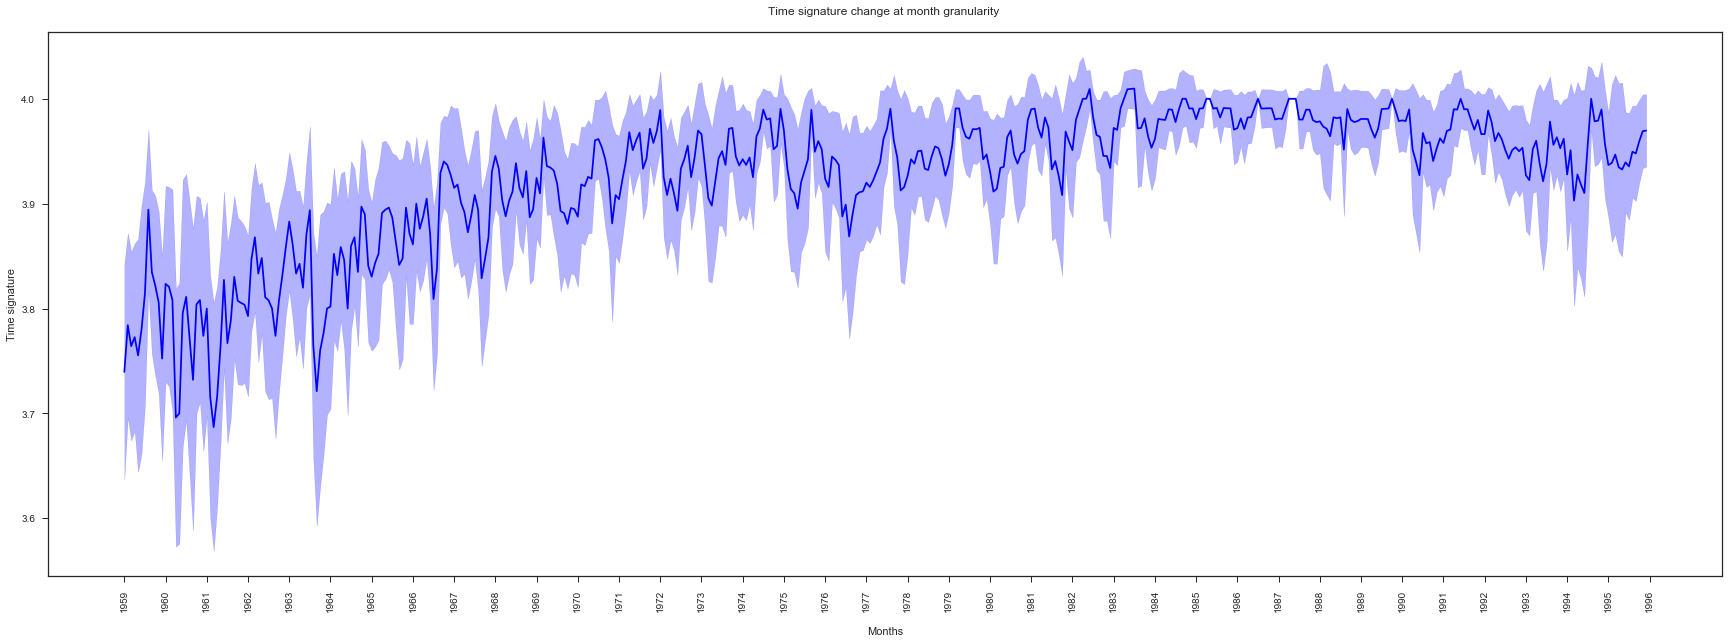

In [47]:
plot_feature_evolution(monthly_features, 'time_signature', N = 12, granularity = 'Months');

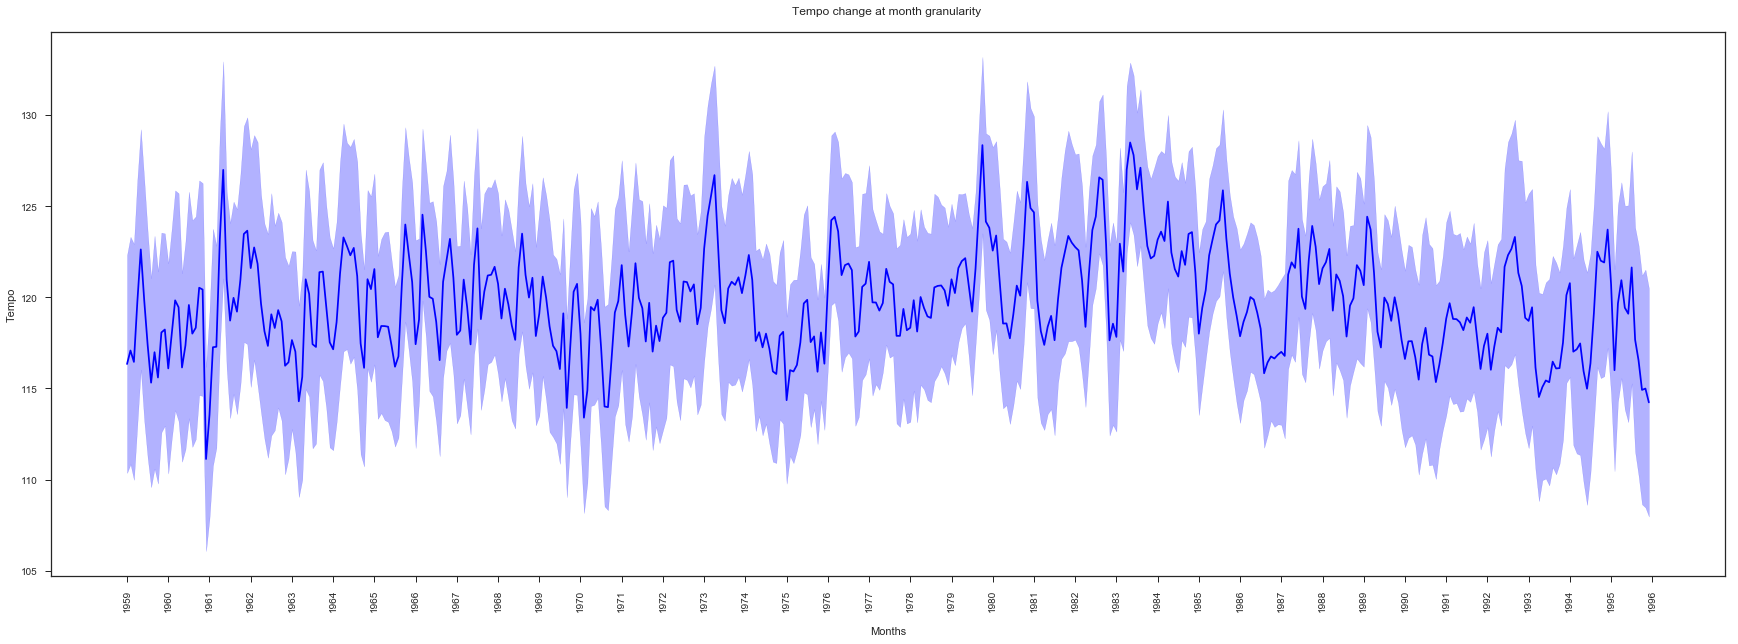

In [48]:
plot_feature_evolution(monthly_features, 'tempo', N = 12, granularity = 'Months');

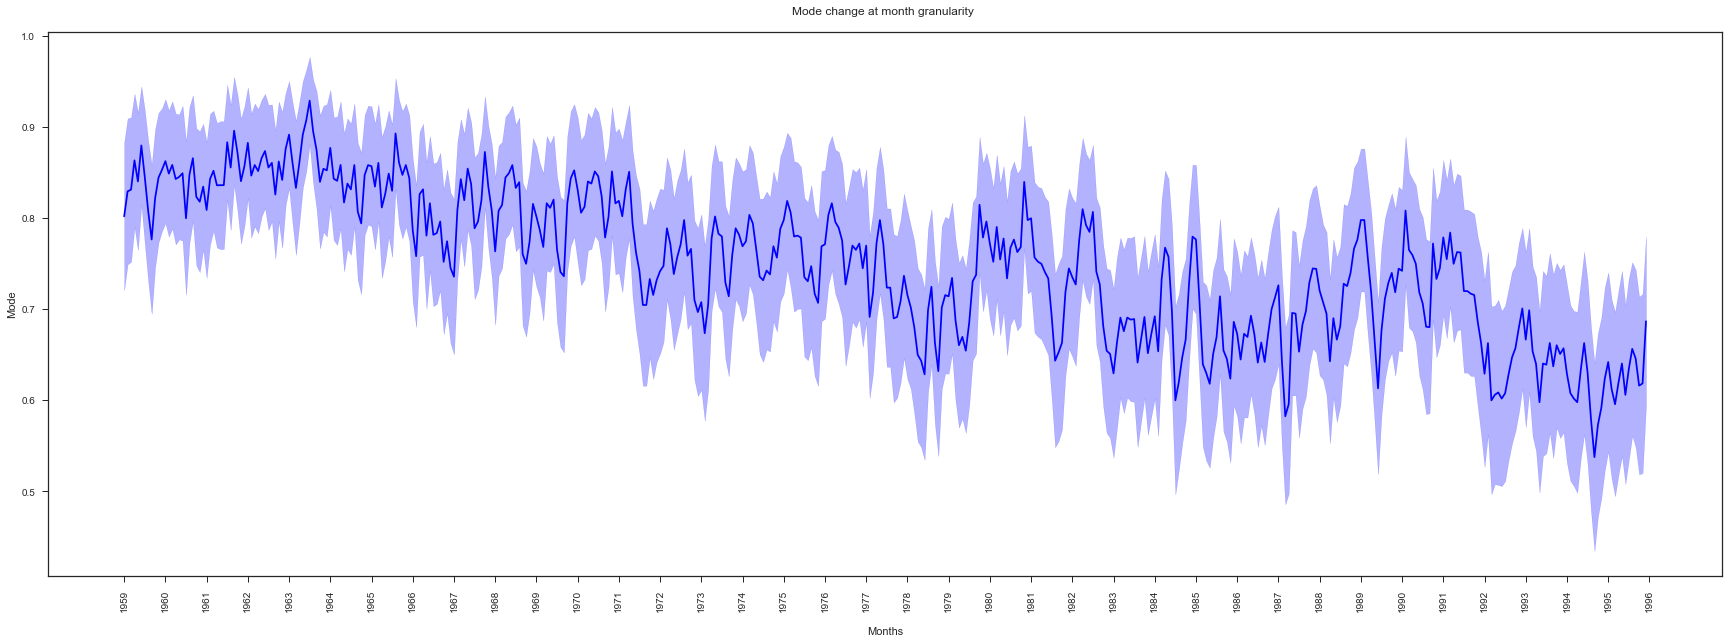

In [49]:
plot_feature_evolution(monthly_features, 'mode', N = 12, granularity = 'Months');

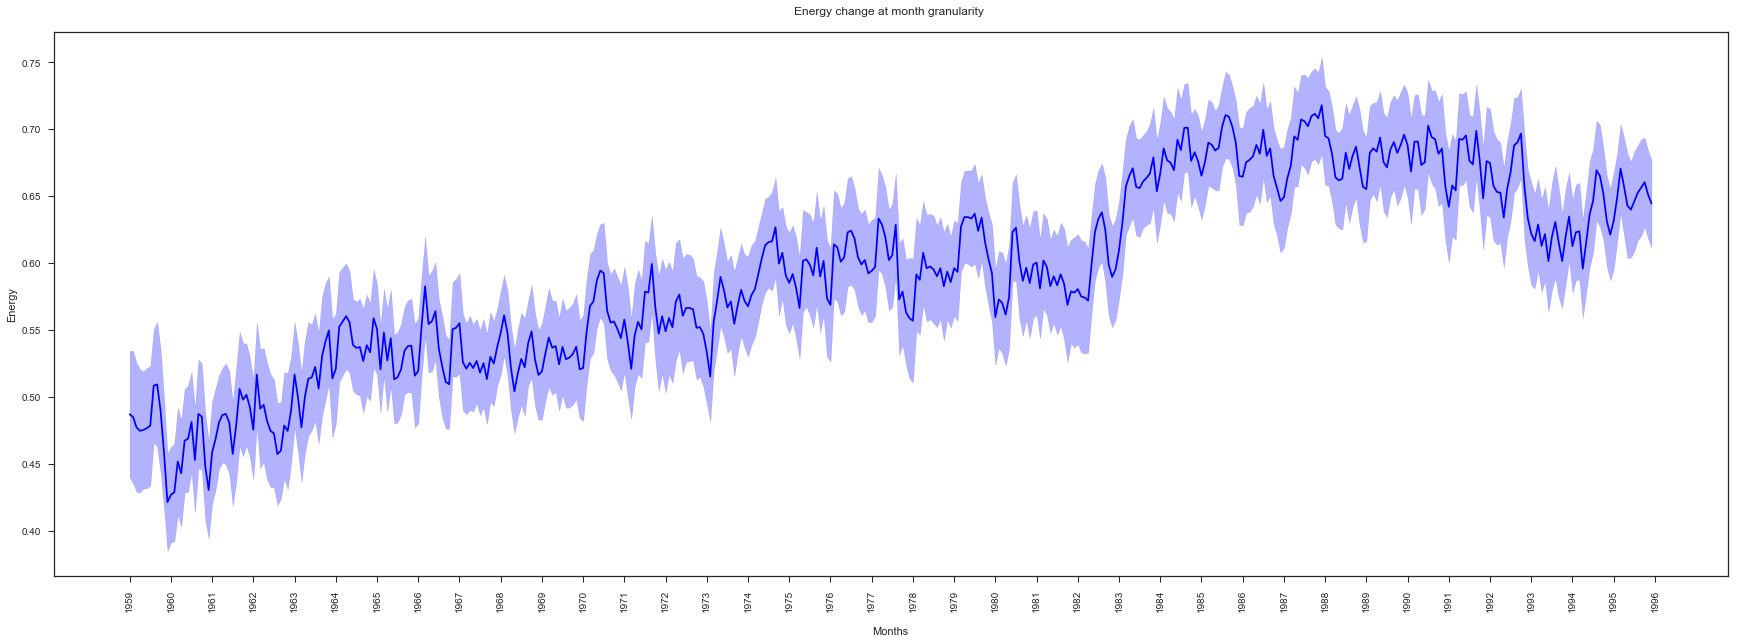

In [50]:
plot_feature_evolution(monthly_features, 'energy', N = 12, granularity = 'Months');

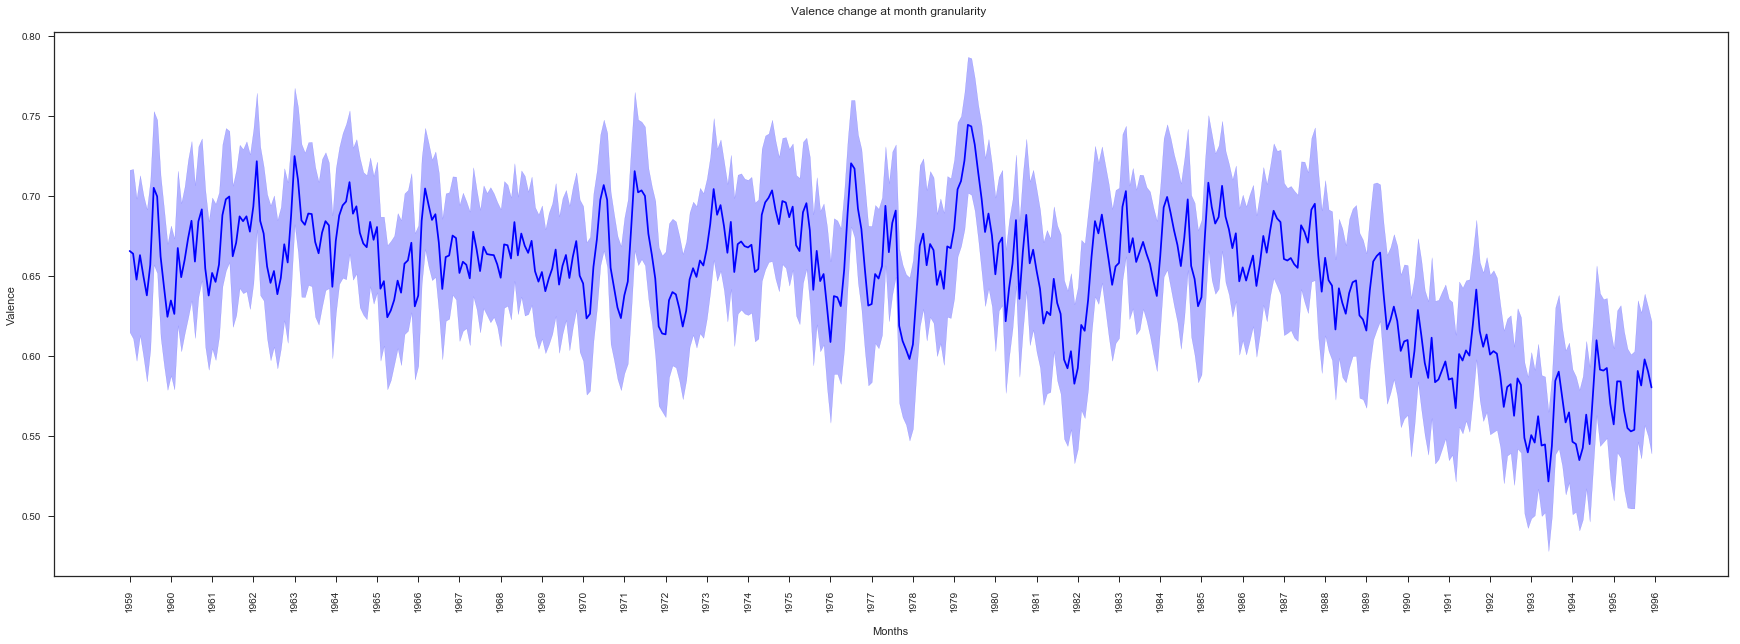

In [51]:
plot_feature_evolution(monthly_features, 'valence', N = 12, granularity = 'Months');

# Years

In [52]:
years_list = []

for ind, item in df['weeks_list'].iteritems():
    occurences = [] 
    
    for week in item:
        year = week[:4]
        if not(year in occurences):
            occurences.append(year)
            
    years_list.append(occurences)
    
df['years_list'] = years_list

In [53]:
all_years = []

for ind, item in df['years_list'].iteritems():
    for year in item:
        all_years.append(year)
        
years = pd.Series(all_years).value_counts().index

In [54]:
years = sorted(years)[1:]

In [55]:
yearly_features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [56]:
keys = yearly_features.keys()

for year in years :
    year_features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
        
    for ind, row in df.iterrows():
        if year in row['years_list']: 
            for key in keys:
                if float(row[key]) != -1.:
                    year_features[key].append(row[key])
    
    for key in keys:
        yearly_features[key].append(year_features[key])

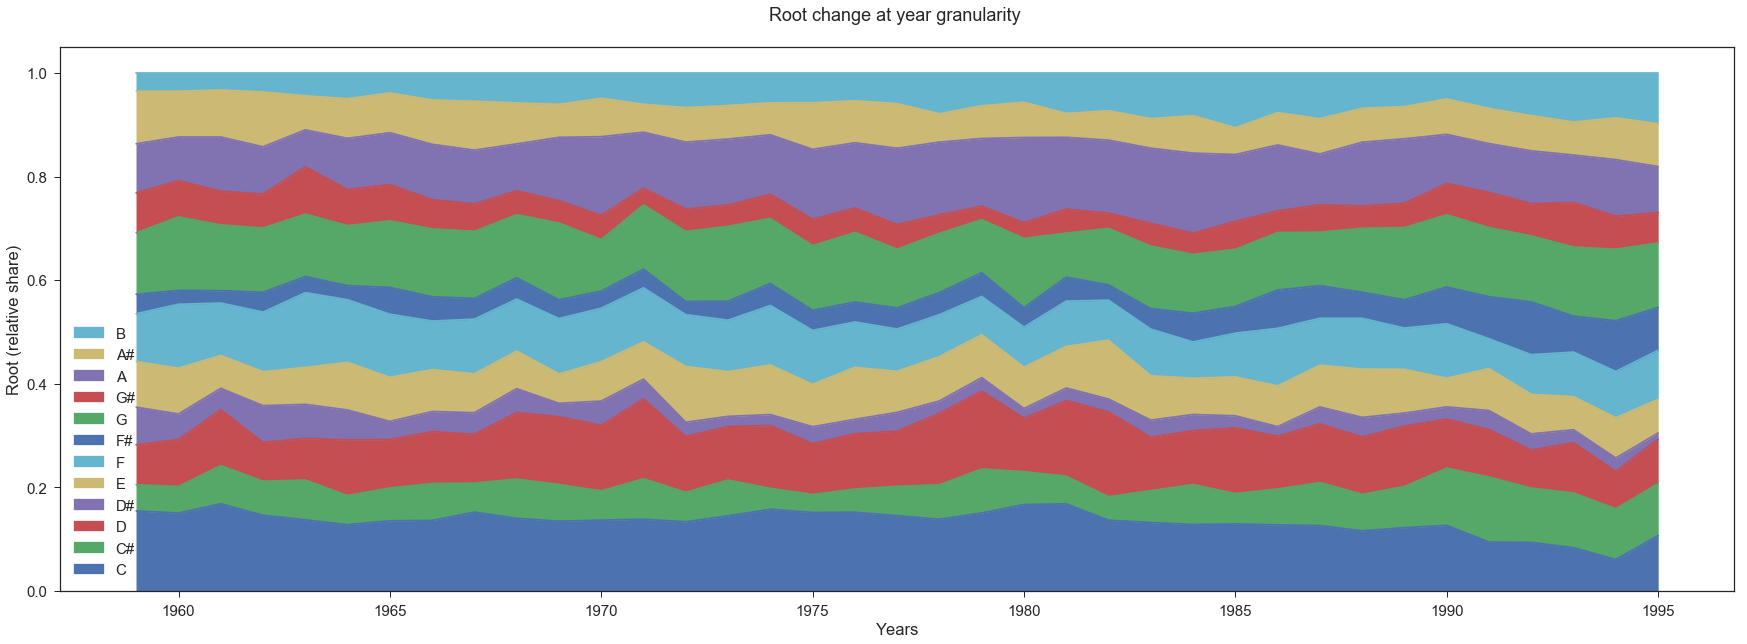

In [136]:
plot_discrete_feature_evolution(yearly_features, 'root', granularity = 'Years', categories =
                               ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A',
                                'A#', 'B']);

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

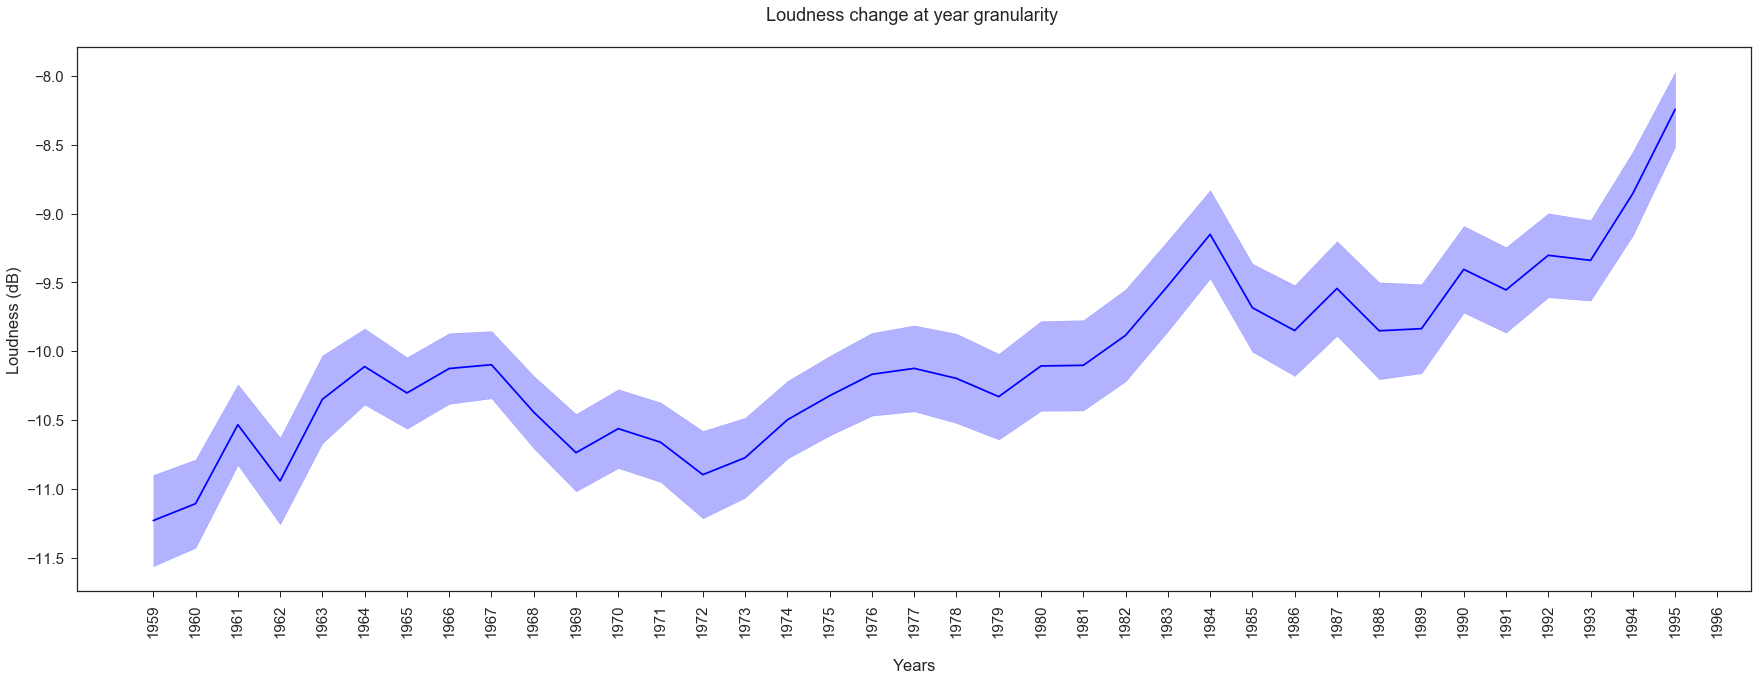

In [33]:
plot_feature_evolution(yearly_features, 'loudness', N = 1, granularity = 'Years', unit = '(dB)')

In [245]:
yearly_features = yearly_features.rename(columns = {'duration':'duration_ms'})

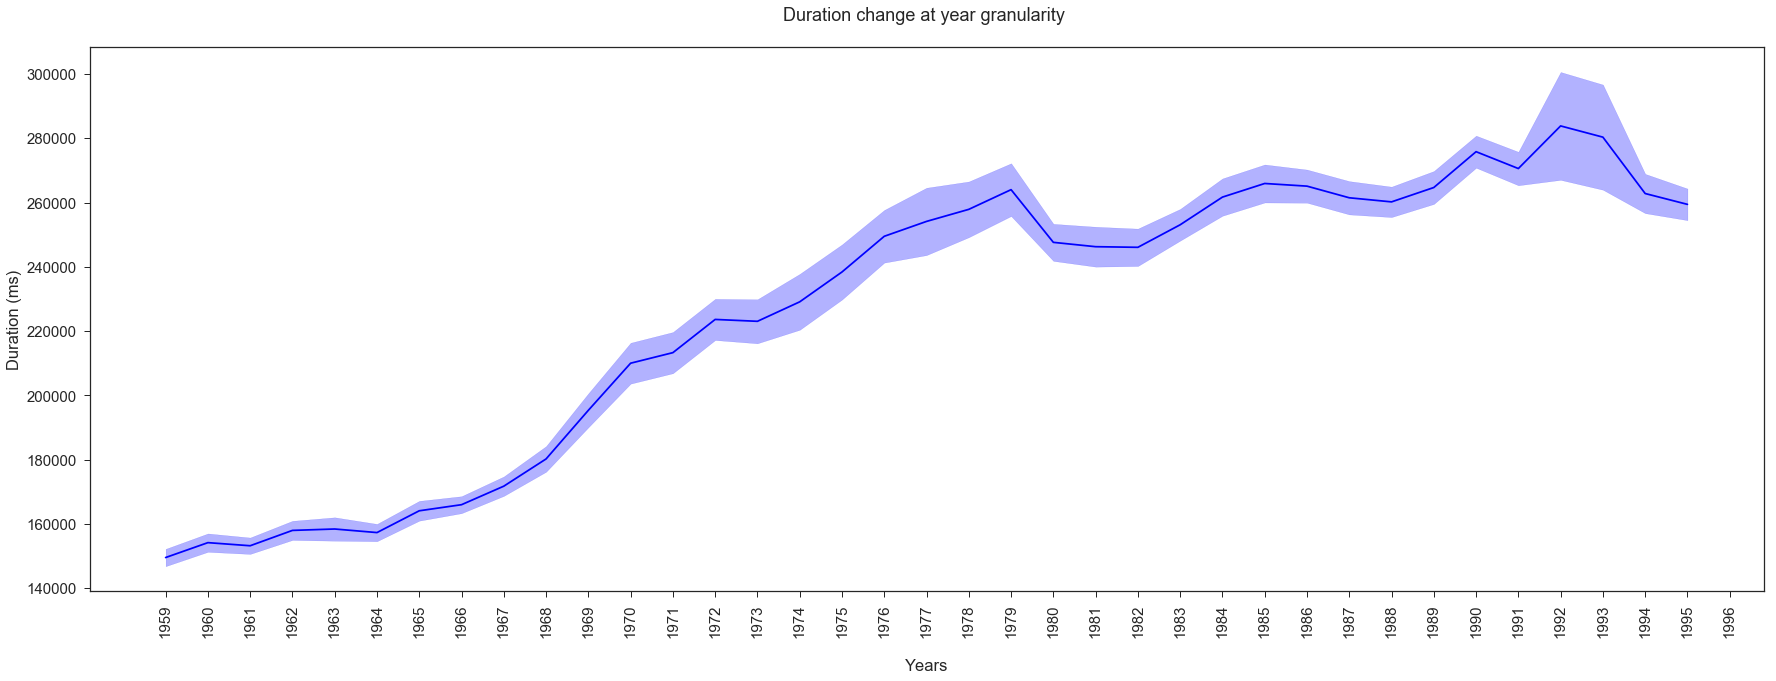

In [34]:
plot_feature_evolution(yearly_features, 'duration', N = 1, granularity = 'Years', unit = '(ms)');

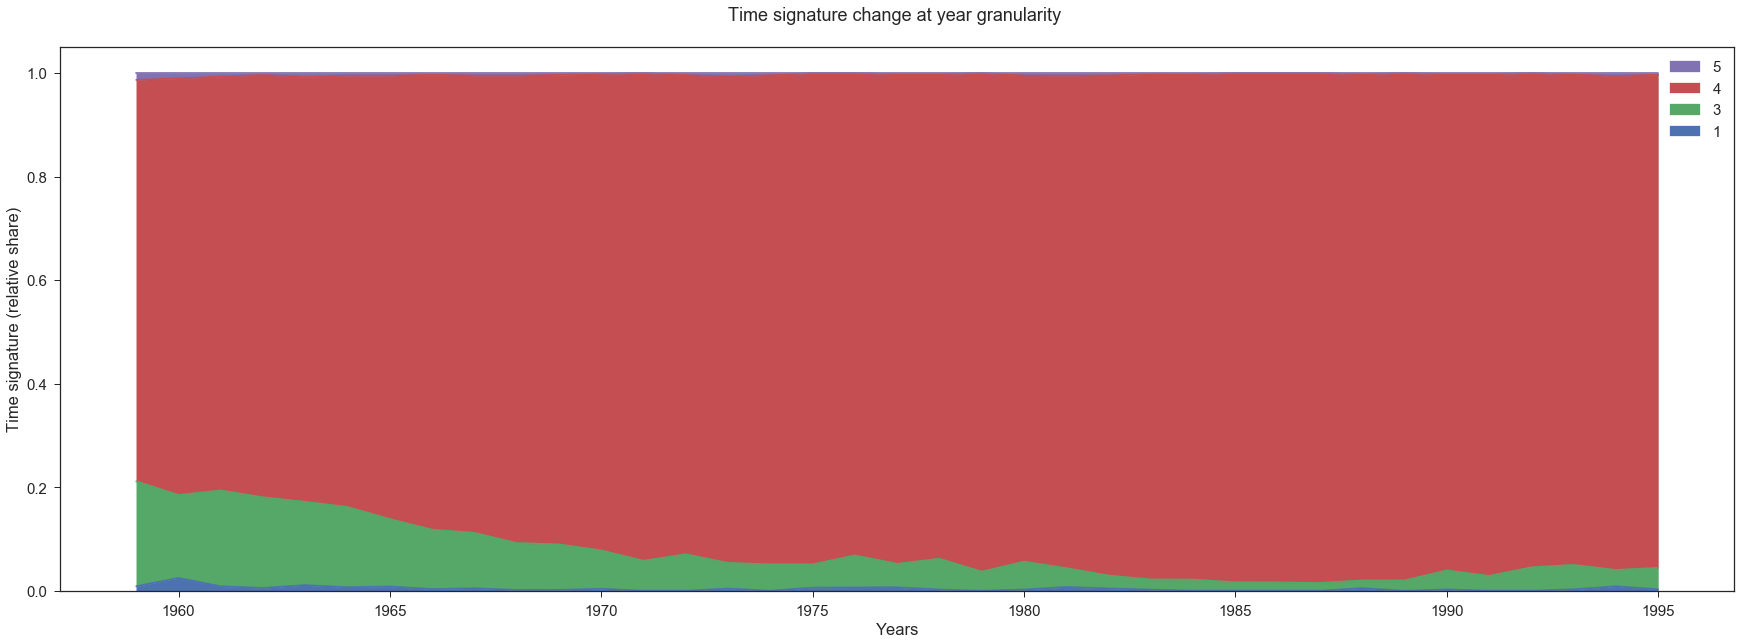

In [142]:
plot_discrete_feature_evolution(yearly_features, 'time_signature', granularity = 'Years');

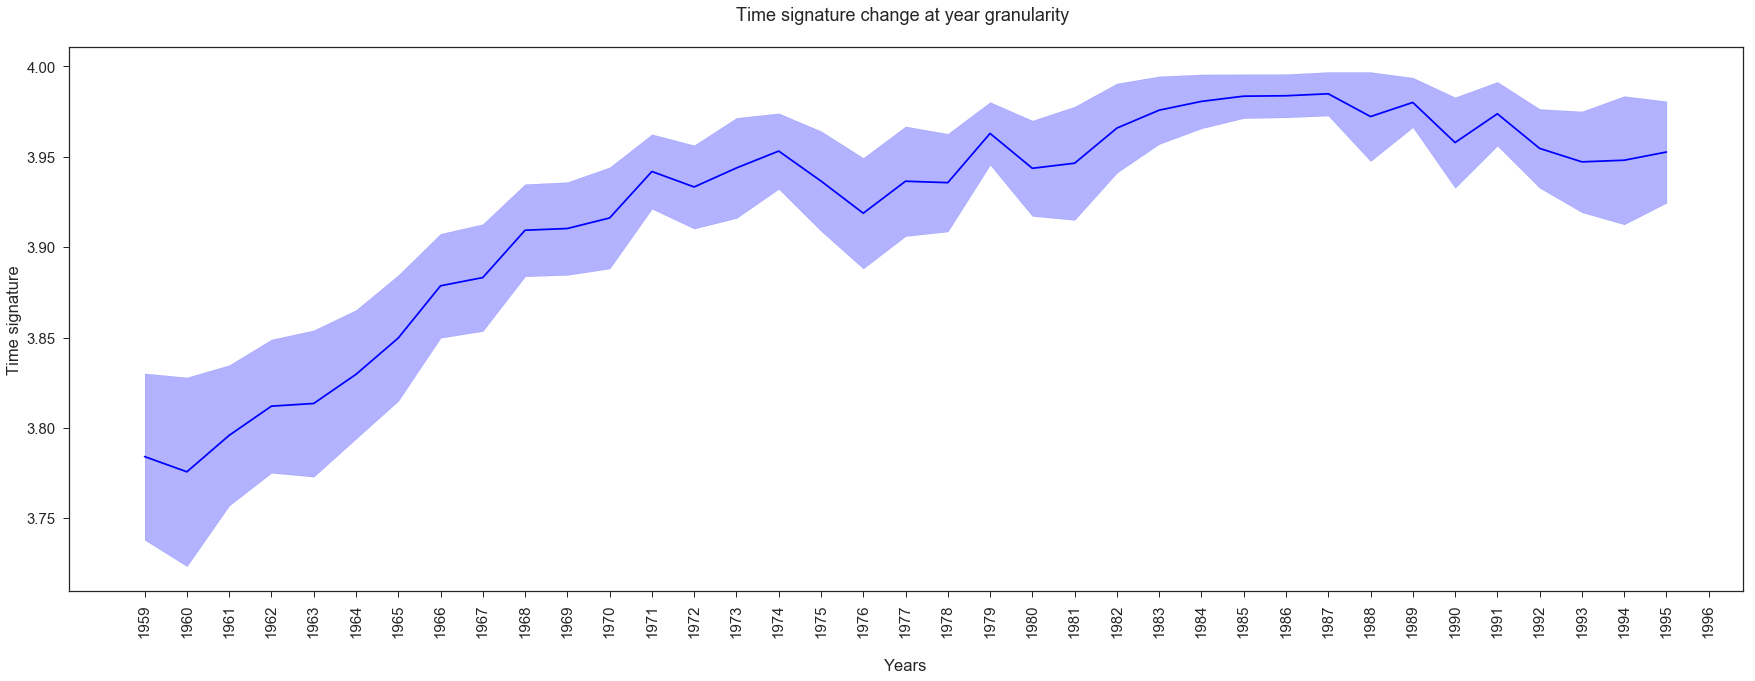

In [20]:
plot_feature_evolution(yearly_features, 'time_signature', N = 1, granularity = 'Years');

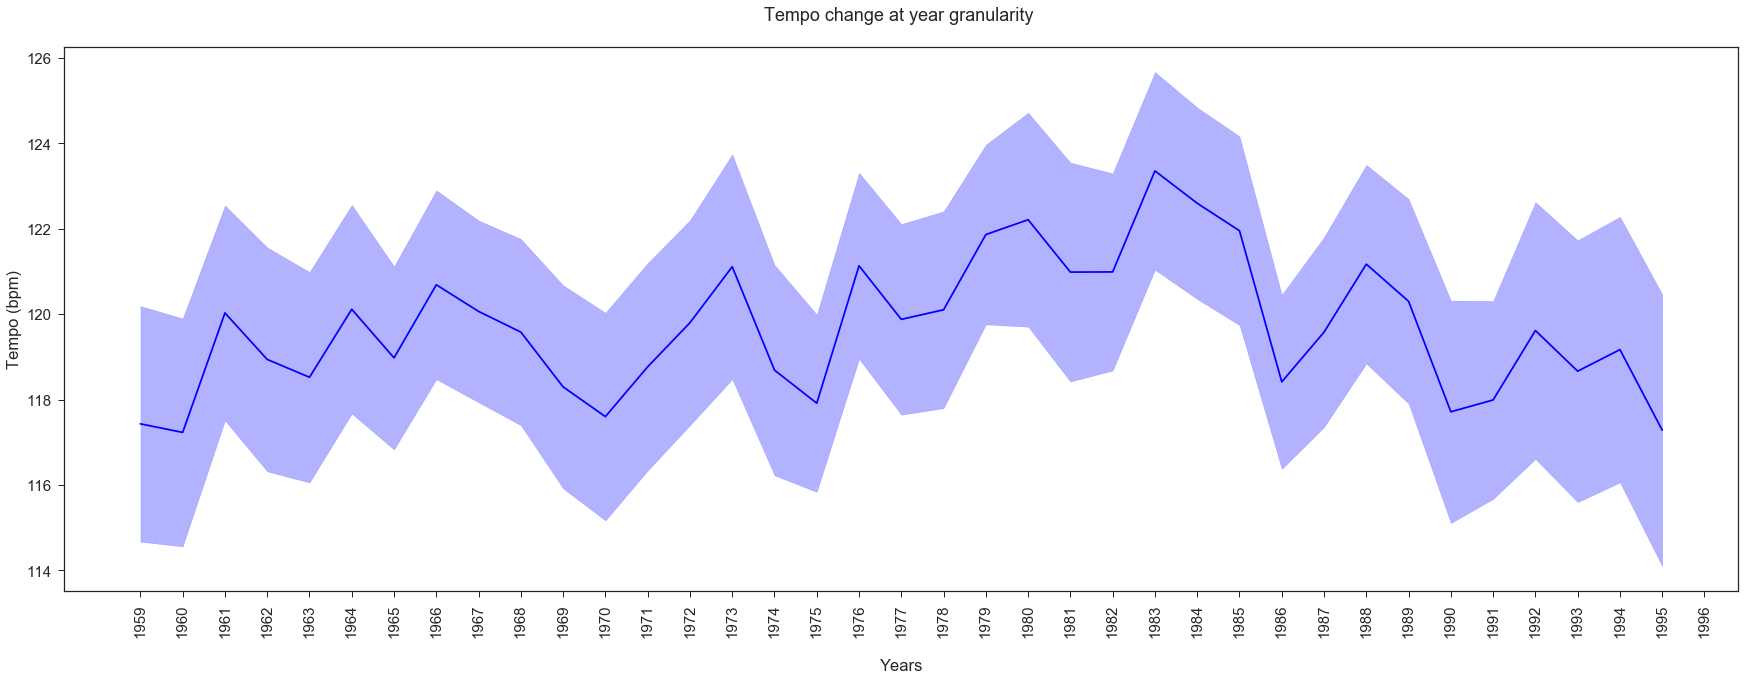

In [35]:
plot_feature_evolution(yearly_features, 'tempo', N = 1, granularity = 'Years', unit = '(bpm)');

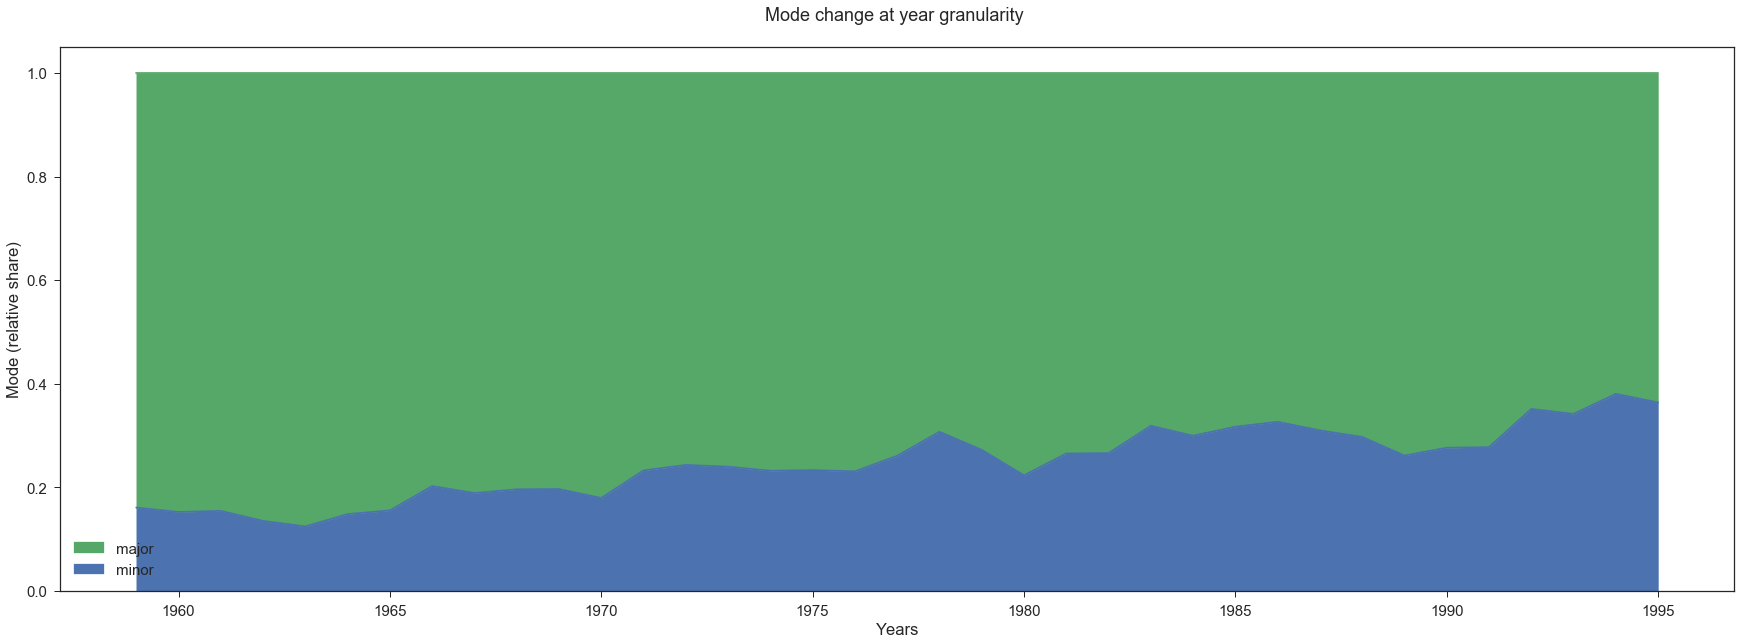

In [145]:
plot_discrete_feature_evolution(yearly_features, 'mode', granularity = 'Years', categories = ['minor', 'major']);

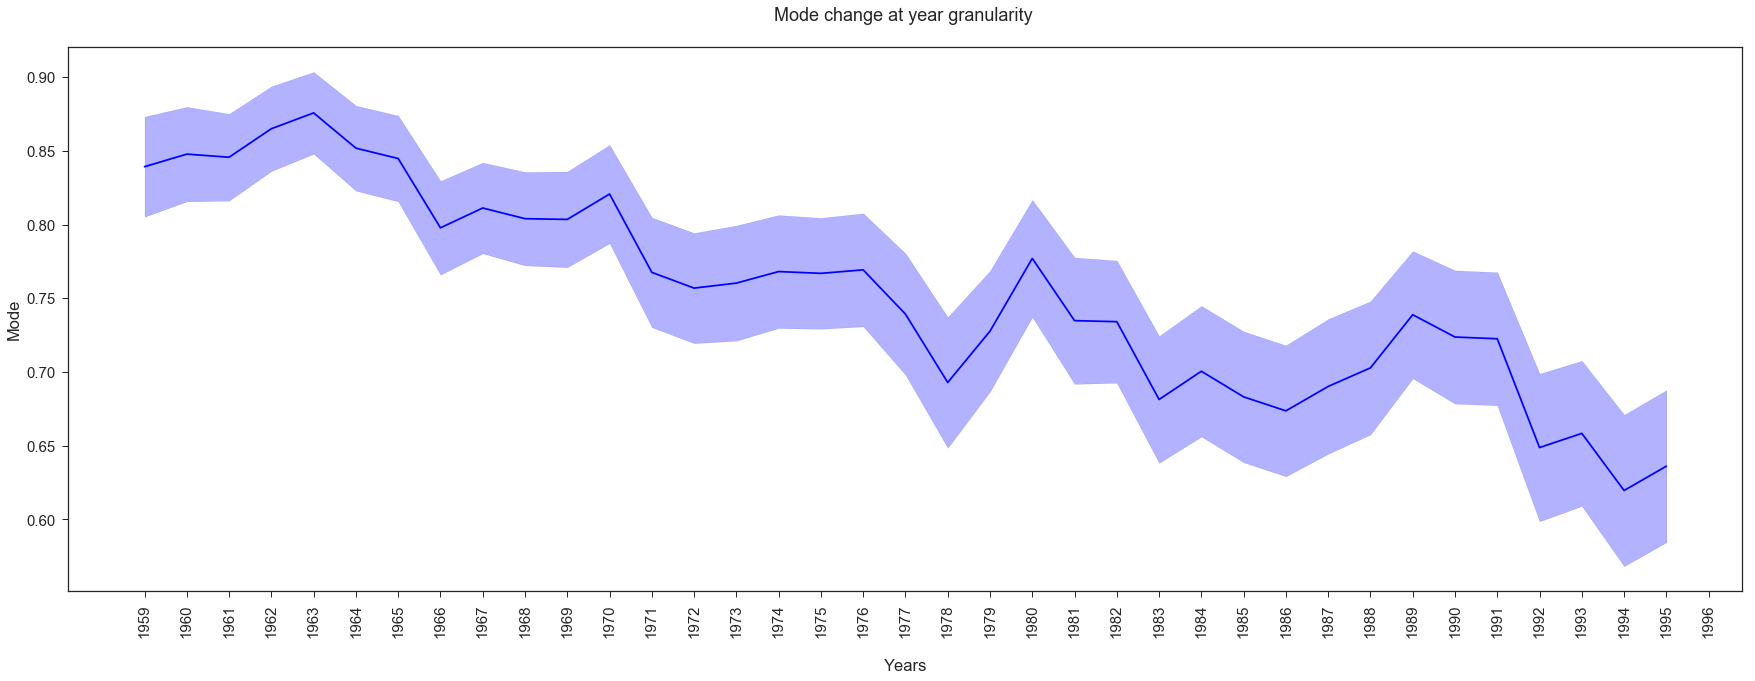

In [22]:
plot_feature_evolution(yearly_features, 'mode', N = 1, granularity = 'Years', unit = '(0 = minor, 1 = major)');

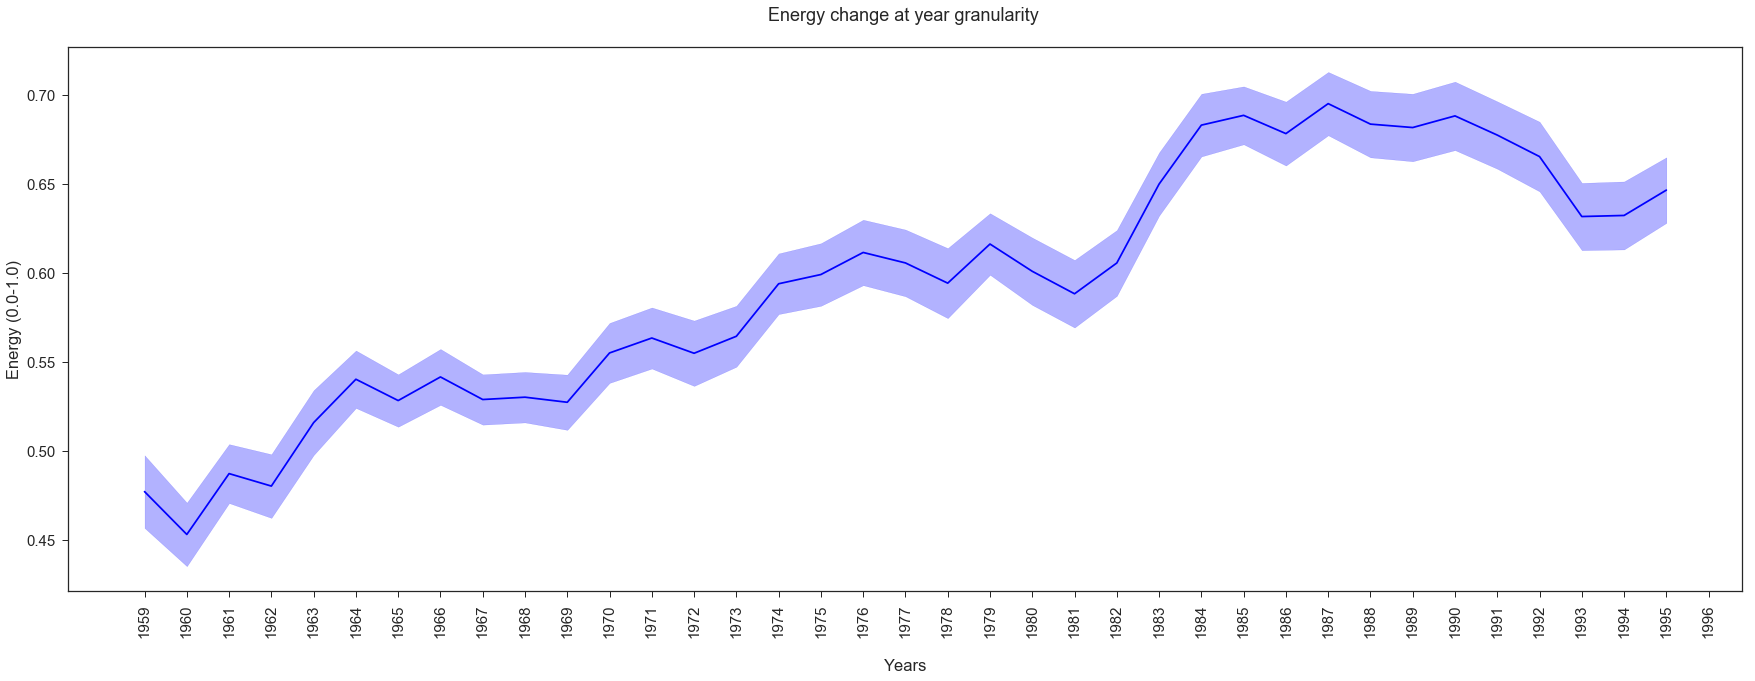

In [36]:
plot_feature_evolution(yearly_features, 'energy', N = 1, granularity = 'Years', unit = '(0.0-1.0)');

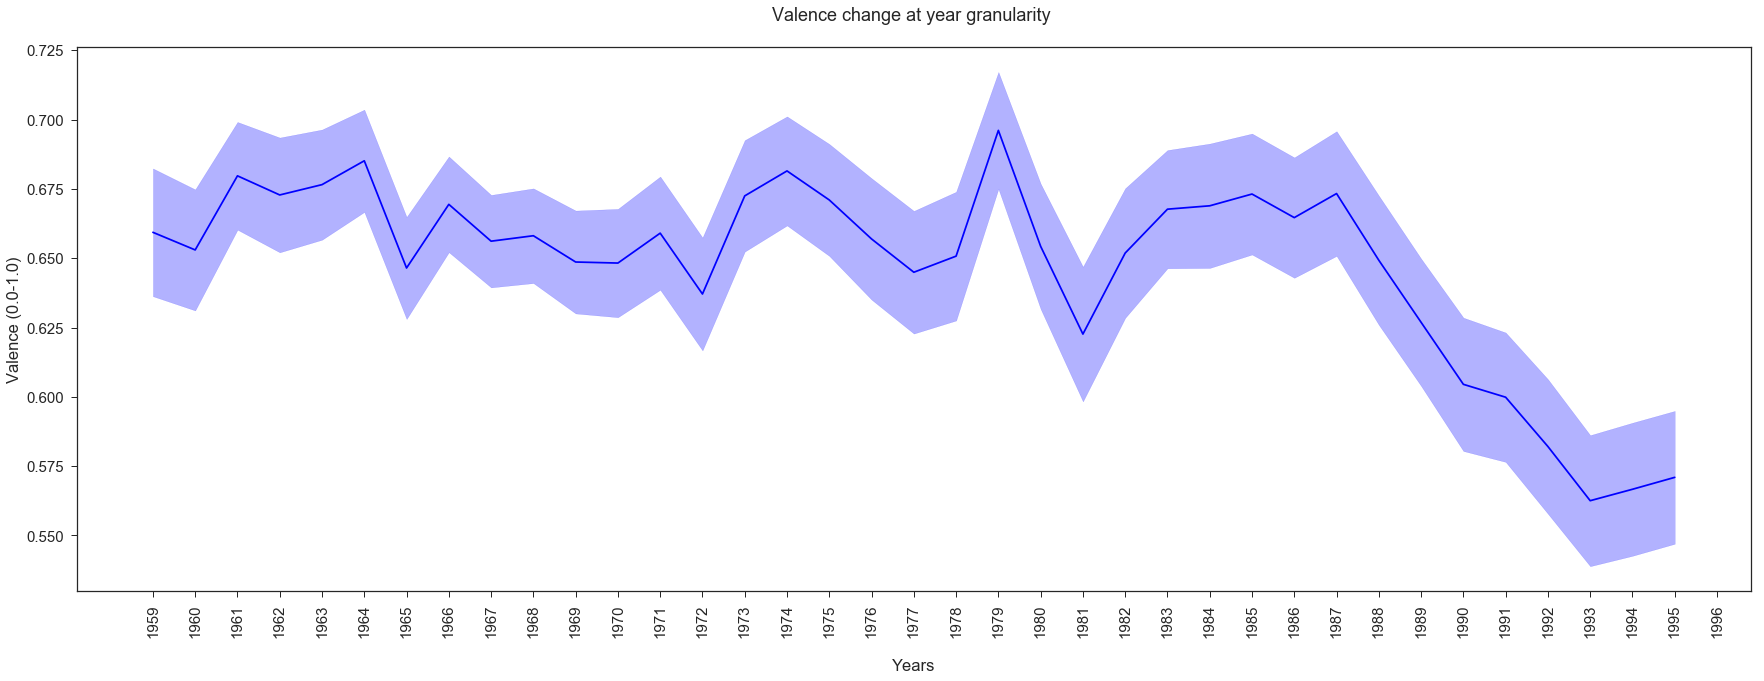

In [37]:
plot_feature_evolution(yearly_features, 'valence', N = 1, granularity = 'Years', unit = '(0.0-1.0)');

# Degree salience

In [386]:
functions = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

smoothed = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [387]:
years = np.arange(1959, 1996)

In [388]:
keys = functions.keys()

In [389]:
first, last = {}, {}

for key in keys:
    first[key] = yearly_features[key][0]
    last[key] = yearly_features[key][36]

In [390]:
for key in keys:
    for i in range(2):
        functions[key].append(first[key])
    for i in range(len(years)):
        functions[key].append(yearly_features[key][i])
    for i in range(2):
        functions[key].append(last[key])

In [391]:
for key in keys:
    for i in range(len(years)):
        values = []
        for j in range(i, i+5):
            for element in functions[key][j]:
                values.append(element)
        smoothed[key].append(values)

In [392]:
low_bound = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

high_bound = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [393]:
for key in keys:
    for i in range(len(years)):
        m, lb, ub = mean_confidence_interval(smoothed[key][i], confidence=0.95)
        low_bound[key].append(lb)
        high_bound[key].append(ub)

In [394]:
def degree_salient_drift(features, feature, low_bound, high_bound, N = 48, granularity = 'Months'):    
    
    color = '#989898'
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    salient_low, salient_high = [], []
    ampl_low, ampl_high = [], []
    
    for i in range(len(lower_bound)):
        if lower_bound[i] > high_bound[feature][i//N]:
            salient_high.append(i)
            ampl_high.append(mean[i])
            
        if upper_bound[i] < low_bound[feature][i//N]:
            salient_low.append(i)
            ampl_low.append(mean[i])

    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=1.5)
    
    years = np.arange(1959, 1997)
    #plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    plt.plot(salient_low, ampl_low, color='#01B9FF', marker='o', linestyle = '')
    plt.plot(salient_high, ampl_high, color='#FF0101', marker='o', linestyle = '')
    
    name = feature.replace('_', ' ').capitalize()
    if feature == 'duration_ms':
        name = 'Duration'
    plt.xticks(np.arange(0, (len(years))*N, N), years, rotation = 'vertical')
    plt.xlabel('\n Years')
    plt.ylabel(name)
    plt.title(name + ' salient drifts at ' + granularity.lower()[:-1] + ' granularity \n')

    return plt, salient_low, salient_high

In [395]:
salient_low_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
salient_high_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

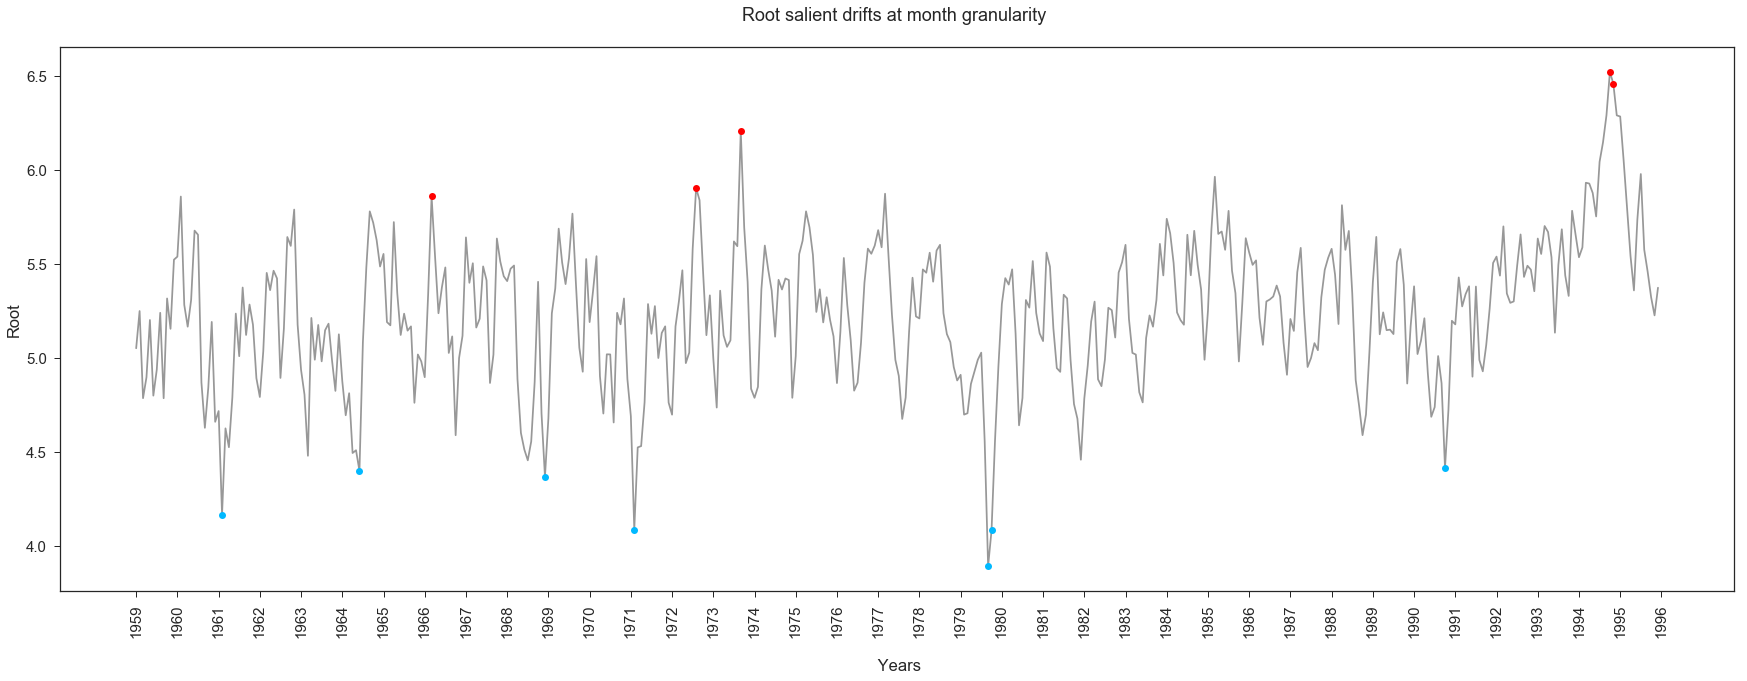

In [396]:
feature = 'root'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

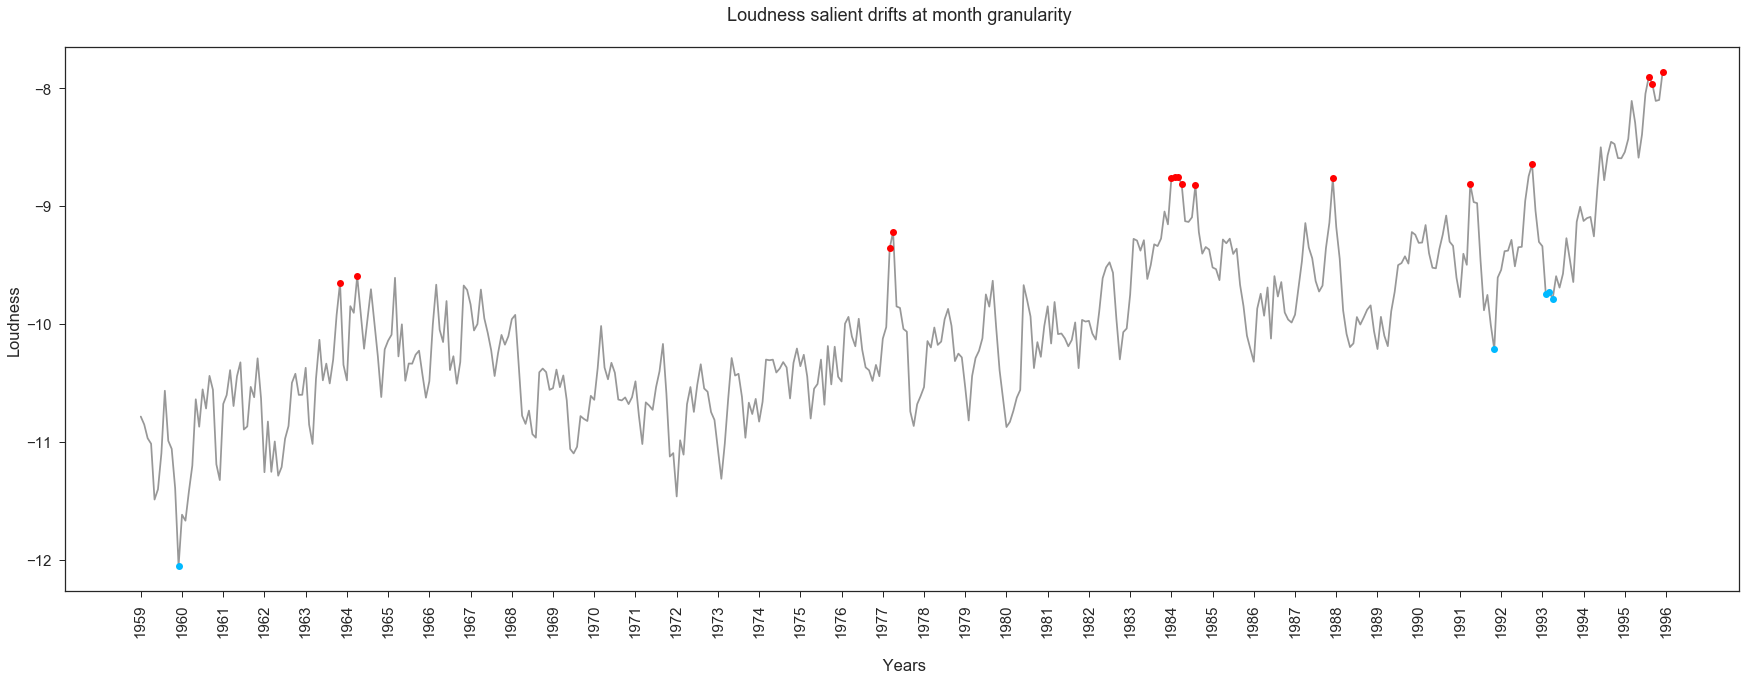

In [397]:
feature = 'loudness'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

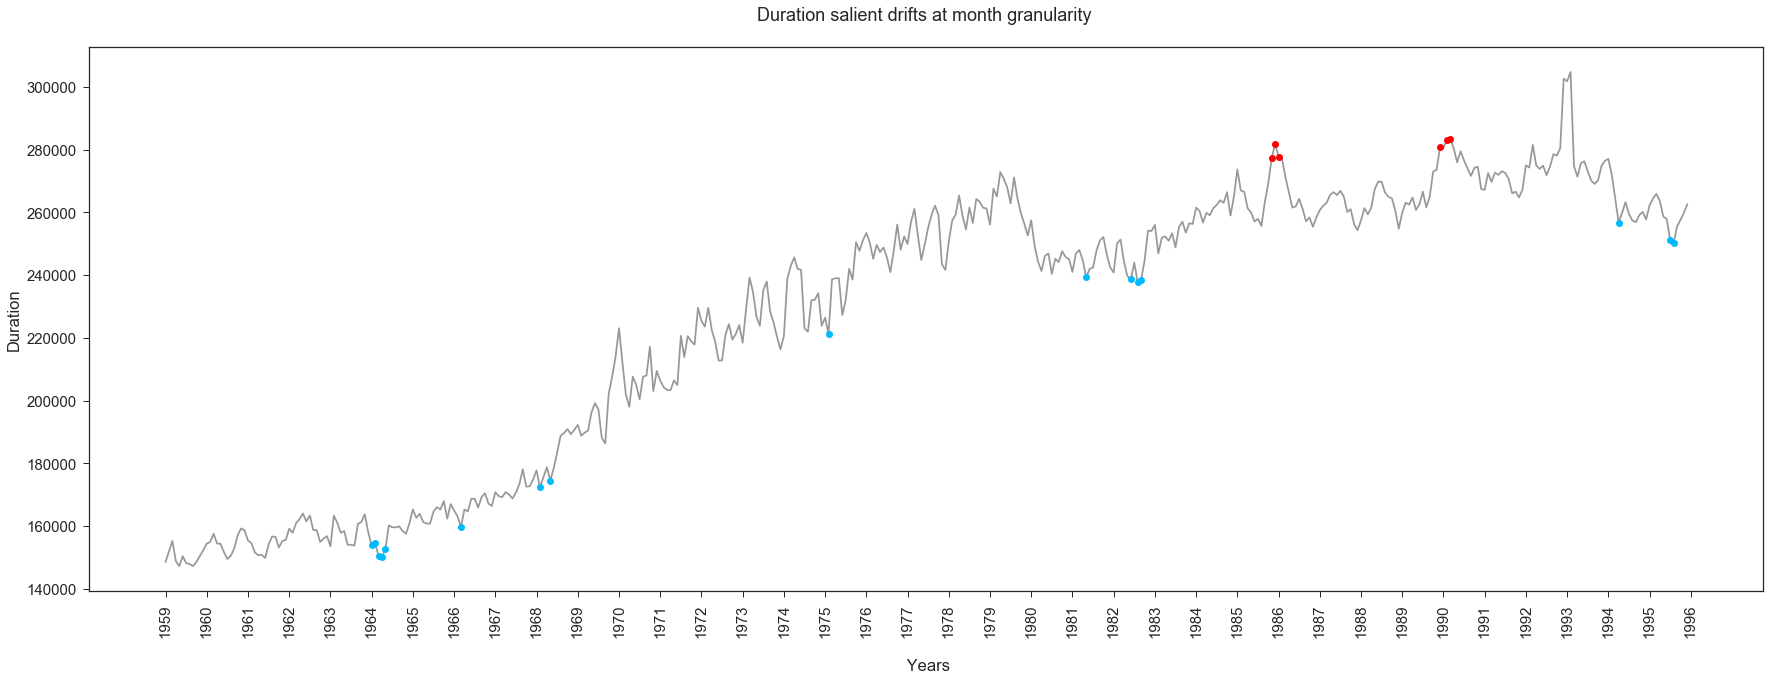

In [398]:
feature = 'duration_ms'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

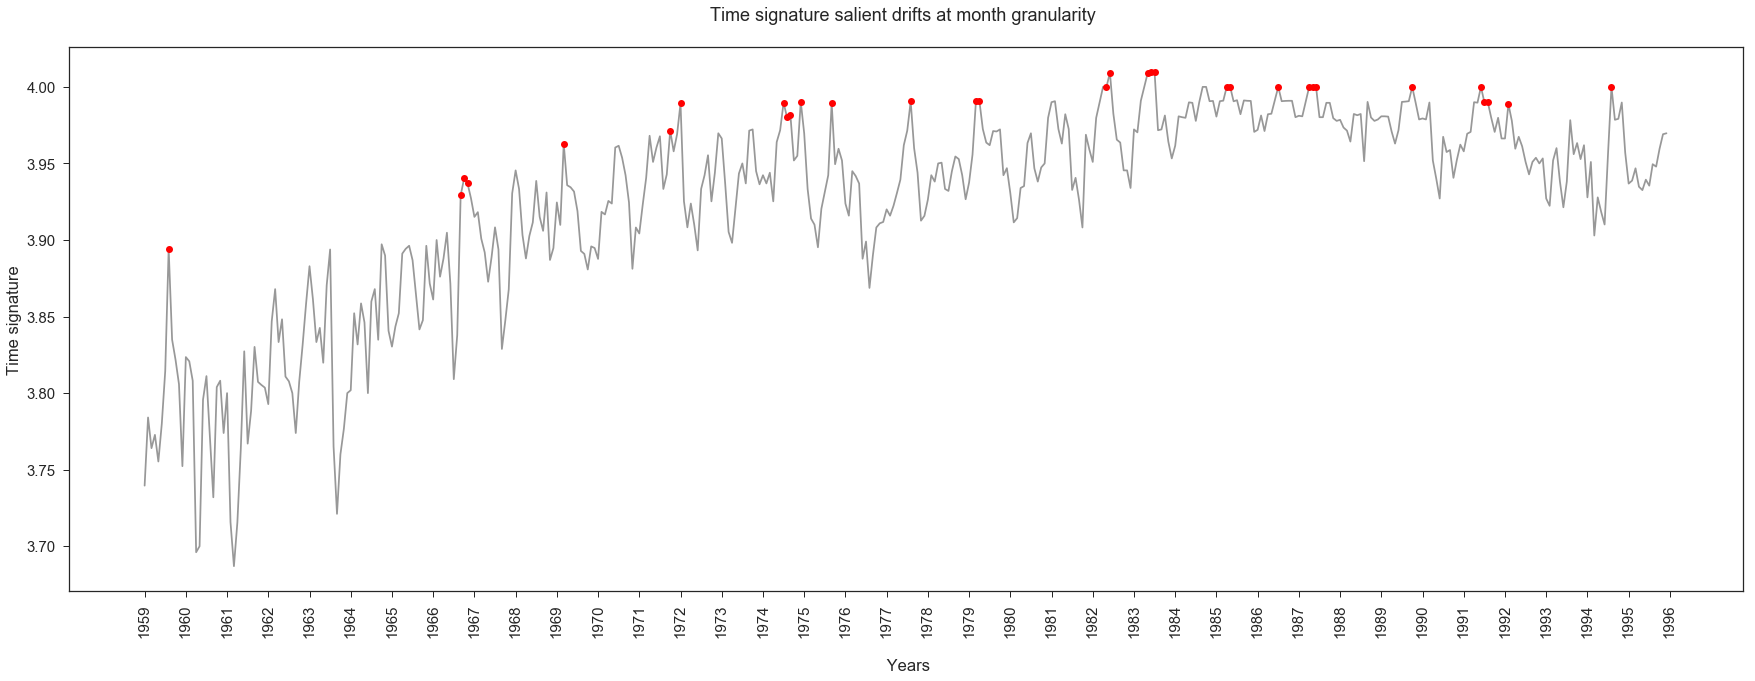

In [399]:
feature = 'time_signature'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

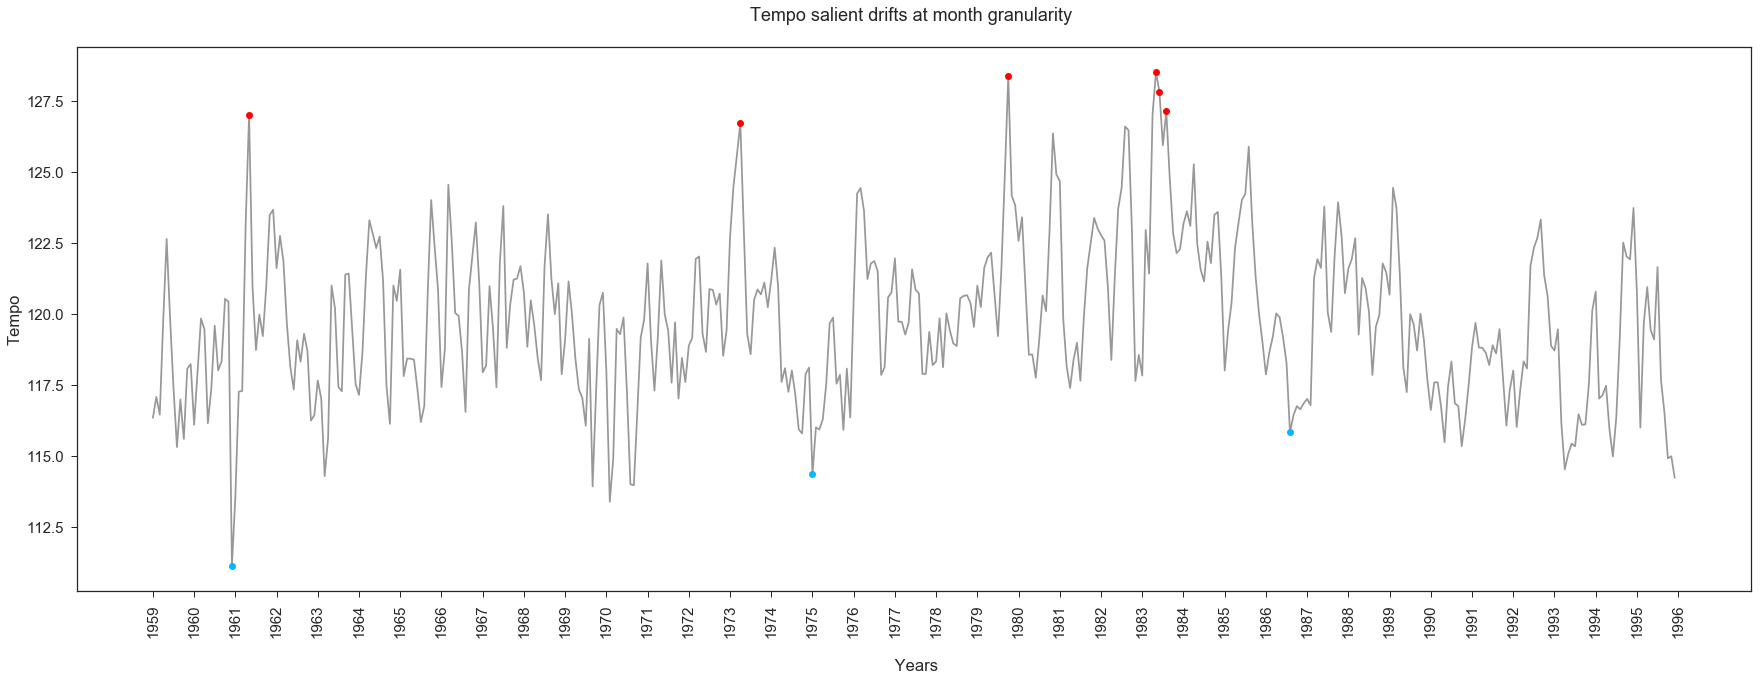

In [400]:
feature = 'tempo'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

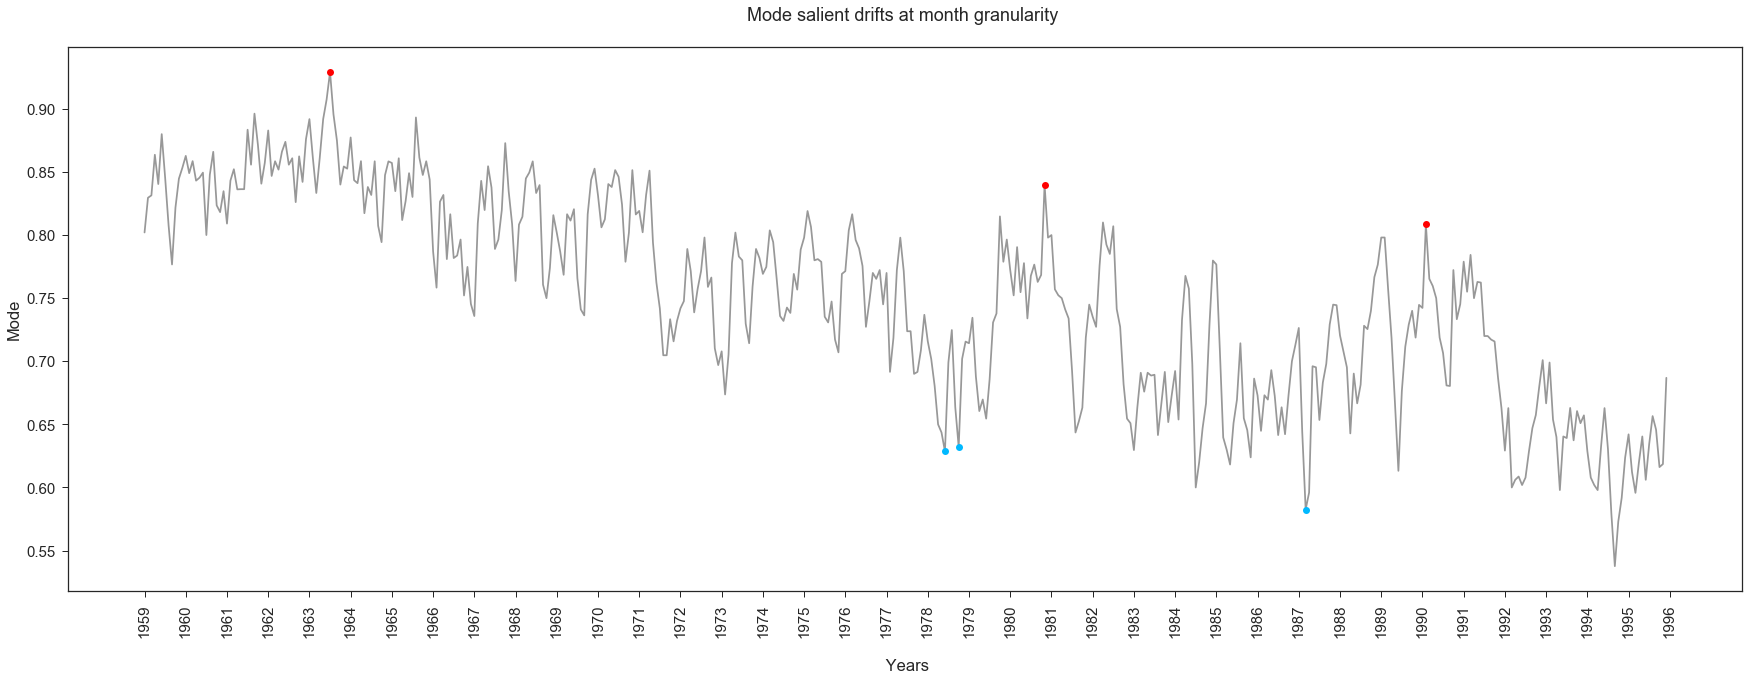

In [401]:
feature = 'mode'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

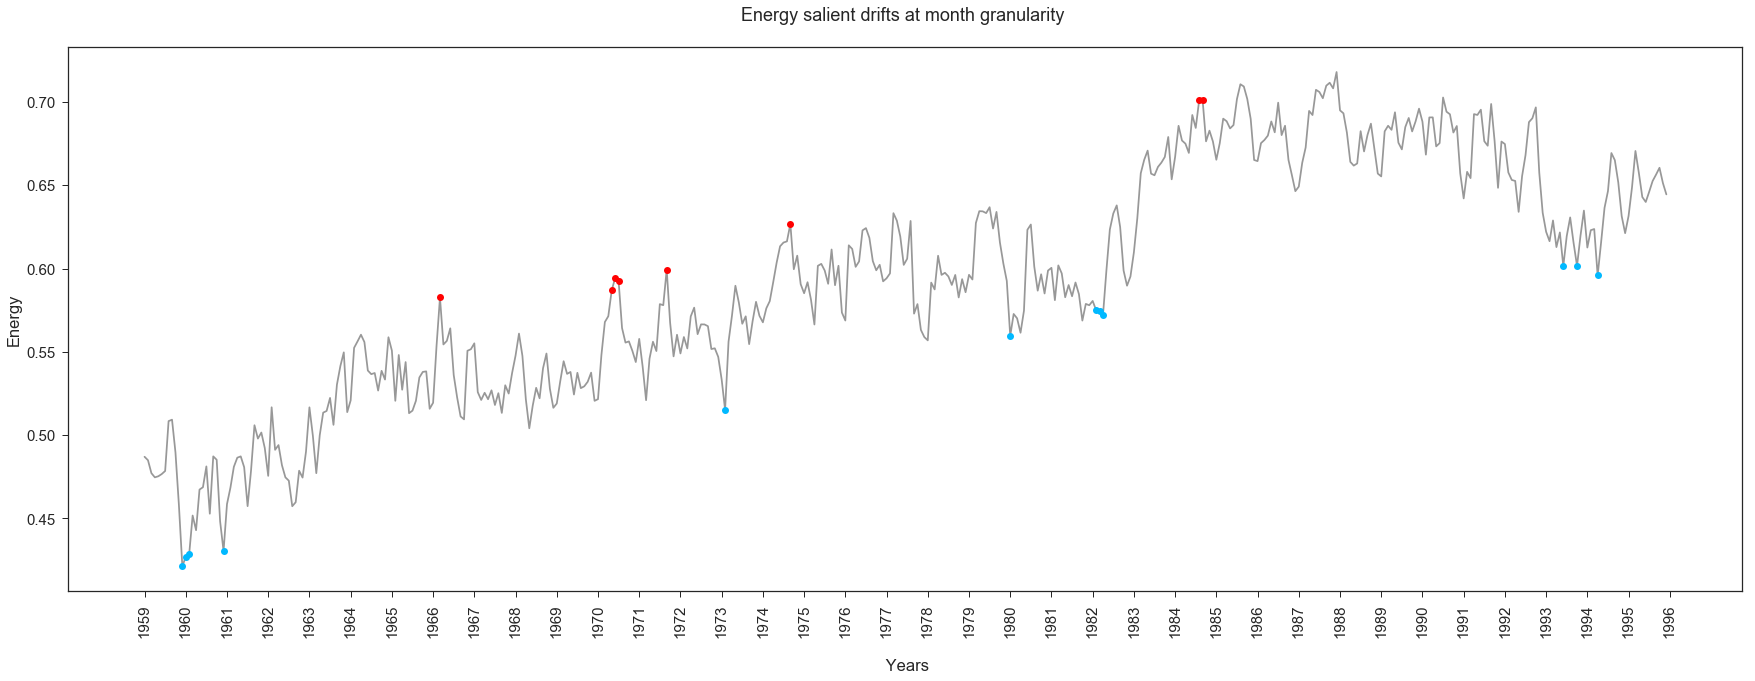

In [402]:
feature = 'energy'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

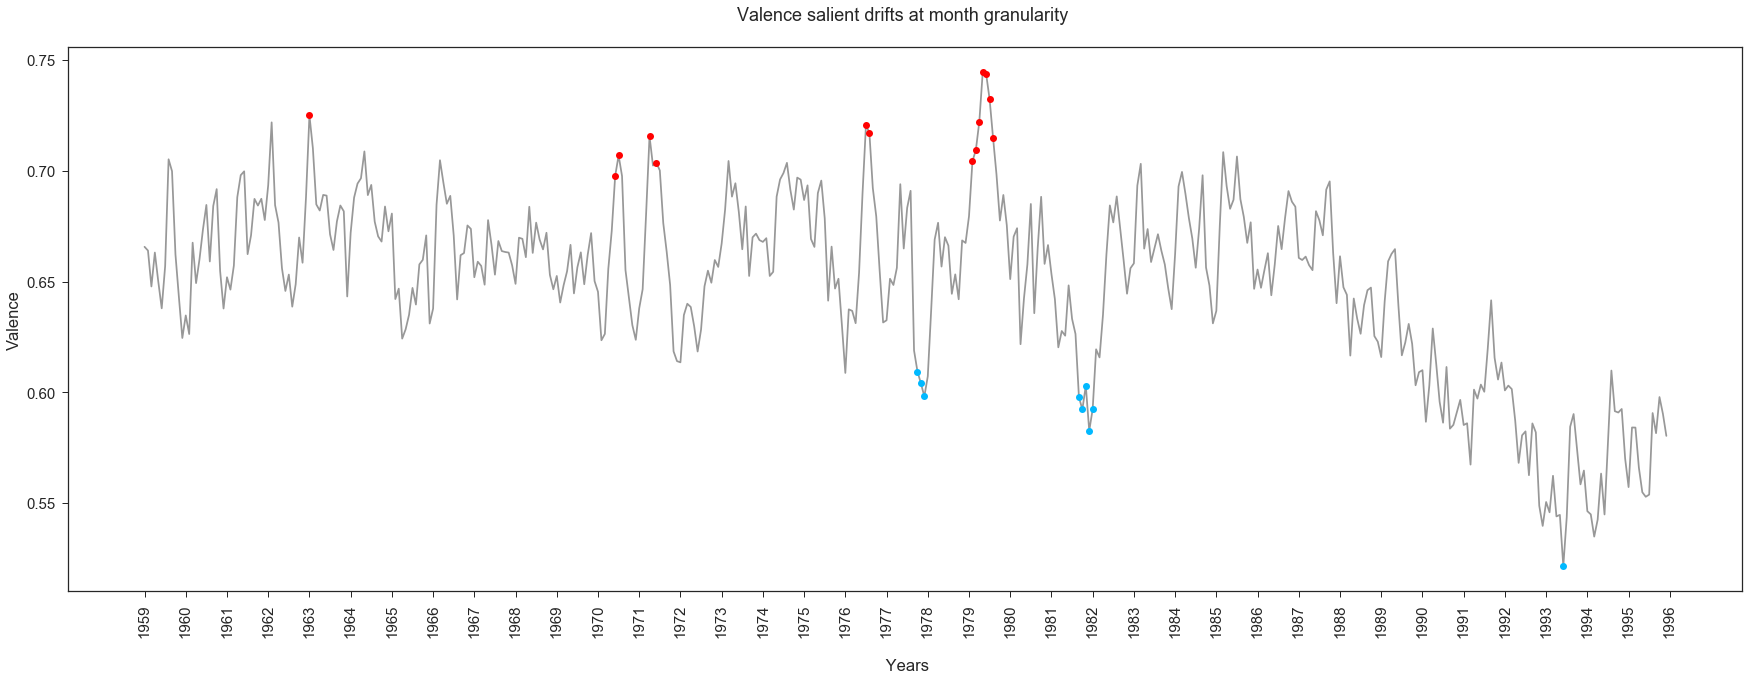

In [403]:
feature = 'valence'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

In [404]:
salient_low_list

{'root': [25, 65, 119, 145, 248, 249, 381],
 'loudness': [11, 394, 409, 410, 411],
 'duration_ms': [60,
  61,
  62,
  63,
  64,
  86,
  109,
  112,
  193,
  268,
  281,
  283,
  284,
  423,
  438,
  439],
 'time_signature': [],
 'tempo': [23, 192, 331],
 'mode': [233, 237, 338],
 'energy': [11, 12, 13, 23, 169, 252, 277, 278, 279, 413, 417, 423],
 'valence': [225, 226, 227, 272, 273, 274, 275, 276, 413]}

In [405]:
salient_high_list

{'root': [86, 163, 176, 429, 430],
 'loudness': [58,
  63,
  218,
  219,
  300,
  301,
  302,
  303,
  307,
  347,
  387,
  405,
  439,
  440,
  443],
 'duration_ms': [322, 323, 324, 371, 373, 374],
 'time_signature': [7,
  92,
  93,
  94,
  122,
  153,
  156,
  186,
  187,
  188,
  191,
  200,
  223,
  242,
  243,
  280,
  281,
  292,
  293,
  294,
  315,
  316,
  330,
  339,
  340,
  341,
  369,
  389,
  390,
  391,
  397,
  427],
 'tempo': [28, 171, 249, 292, 293, 295],
 'mode': [54, 262, 373],
 'energy': [86, 136, 137, 138, 152, 188, 307, 308],
 'valence': [48,
  137,
  138,
  147,
  149,
  210,
  211,
  241,
  242,
  243,
  244,
  245,
  246,
  247]}

In [406]:
drifts = []

for key in salient_low_list.keys():
    for drift in salient_low_list[key]:
        drifts.append(drift)
        
for key in salient_high_list.keys():
    for drift in salient_high_list[key]:
        drifts.append(drift)

In [407]:
count = pd.Series(np.zeros(444), np.arange(0, 444))
drifts_count = pd.Series(drifts).value_counts().sort_index()
drifts_count = pd.concat([drifts_count, count])
drifts_count = pd.DataFrame(drifts_count)
drifts_count['duplicates'] = drifts_count.index
drifts_count = drifts_count.drop_duplicates(subset = 'duplicates', keep = 'first').drop(
    columns = 'duplicates').rename(columns = {0:'Drifts'}).sort_index()

In [408]:
drifts_count.head()

Drifts
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0

Text(0.5,0,'Months (numbered from 1/1959 to 12/1995)')

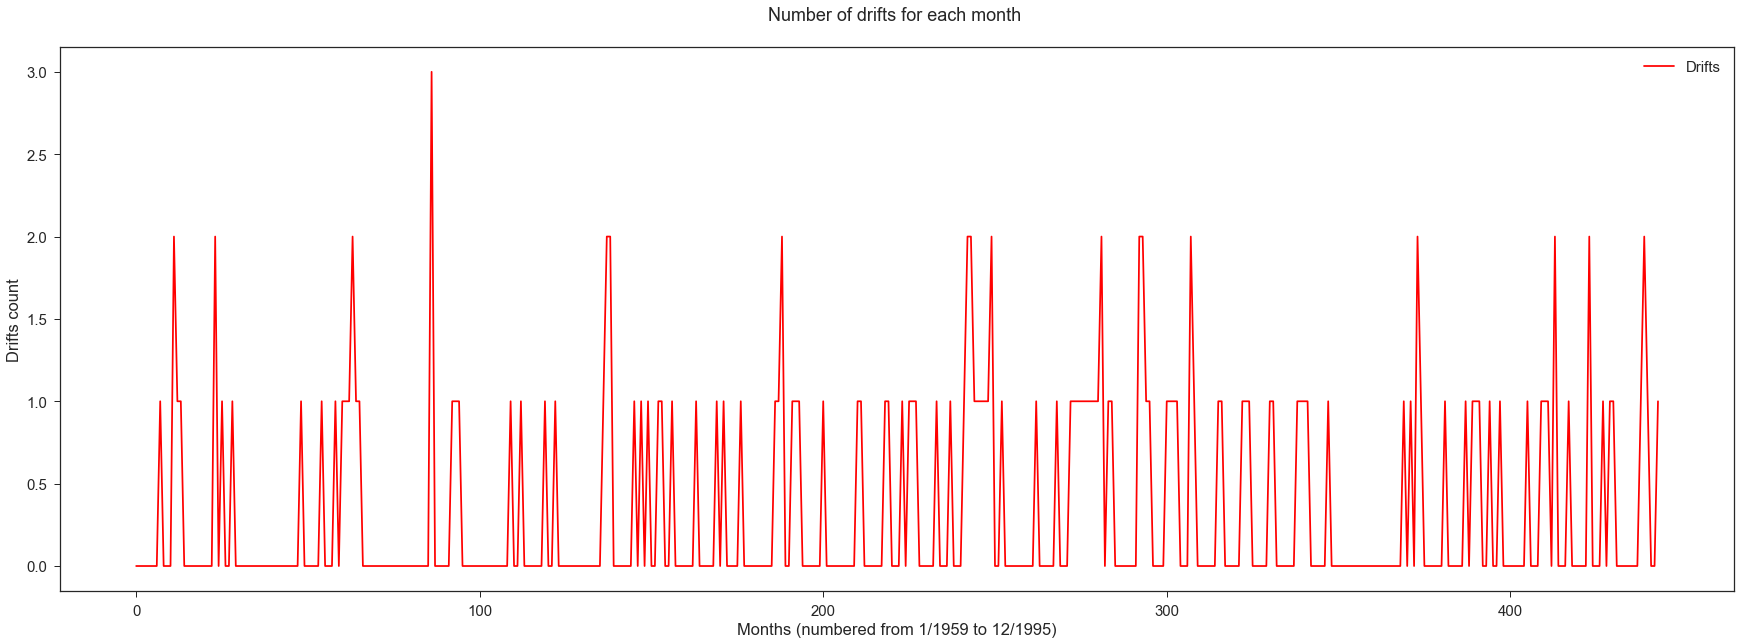

In [409]:
ax = drifts_count.plot(color = 'red', title = 'Number of drifts for each month \n')
ax.set_ylabel('Drifts count')
ax.set_xlabel('Months (numbered from 1/1959 to 12/1995)')